# **Feature Engineering Notebook**

## Objectives

* Engineer features for Classification model

## Inputs

* outputs/datasets/anlysis/TrainSetCleaned.csv* 
outputs/datasetsanalysisd/TestSetCleaned.csv 

## Outputs

* Generate lists of variables 

## Additional Comments

* Feature Engineering Transformers



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Bank-Customer-Churn-Prediction/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/Bank-Customer-Churn-Prediction'

# Load Data

Train Set

In [4]:
import pandas as pd
train_set_path = "outputs/datasets/analysis/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(5)

credit_score  country  gender  age  tenure    balance  products_number  \
0           667        1       0   34       5       0.00                2   
1           427        2       1   42       1   75681.52                1   
2           535        0       0   29       2  112367.34                1   
3           654        1       1   40       5  105683.63                1   
4           850        1       0   57       8  126776.30                2   

   credit_card  active_member  estimated_salary  churn  
0            1              0         163830.64      0  
1            1              1          57098.00      0  
2            1              0         185630.76      0  
3            1              0         173617.09      0  
4            1              1         132298.49      0

Test Set

In [5]:
test_set_path = 'outputs/datasets/analysis/TestSetCleaned.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.head(5)

credit_score  country  gender  age  tenure    balance  products_number  \
0           597        2       0   35       8  131101.04                1   
1           523        0       0   40       2  102967.41                1   
2           706        1       0   42       8   95386.82                1   
3           788        0       1   32       4  112079.58                1   
4           706        2       1   38       5  163034.82                2   

   credit_card  active_member  estimated_salary  churn  
0            1              1         192852.67      0  
1            1              0         128702.10      1  
2            1              1          75732.25      0  
3            0              0          89368.59      0  
4            1              1         135662.17      0

---

## Data Exploration 
* We investigate the Trainset using Panda profiling and perform a Numerical Variable Transformation
* We'll use a numerical variable transformation to transform the variable distribution, ideally to become close to a normal distribution.

In [6]:
import pandas as pd
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Feature Engineering

We implement the custom function in the Code Institute feature-engine lesson material.



In [7]:
%matplotlib inline
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)
    
    return df_feat_eng, list_methods_worked

Potential feature engineering transformers considered to transform the variable distribution, ideally to become close to a normal distribution. * 
Numerical Variable Transformation - Numerical transfor e
r * 
Outlier - Winzo* z
   e * r
Smart Correlation Selection

## Numerical Transformation
Select the Numerical variables except the target variable

In [8]:
variables_engineering = (TrainSet.select_dtypes(include=['float', 'int']).columns.to_list())
variables_engineering.remove('churn')
variables_engineering

['credit_score',
 'country',
 'gender',
 'age',
 'tenure',
 'balance',
 'products_number',
 'credit_card',
 'active_member',
 'estimated_salary']

In [9]:
# Create a DataFrame, with the variables
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(5)

credit_score  country  gender  age  tenure    balance  products_number  \
0           667        1       0   34       5       0.00                2   
1           427        2       1   42       1   75681.52                1   
2           535        0       0   29       2  112367.34                1   
3           654        1       1   40       5  105683.63                1   
4           850        1       0   57       8  126776.30                2   

   credit_card  active_member  estimated_salary  
0            1              0         163830.64  
1            1              1          57098.00  
2            1              0         185630.76  
3            1              0         173617.09  
4            1              1         132298.49

Create the engineered variables and apply the transformations, assess the engineered variables distribution and select the most suitable method for each variable.

* Variable Analyzed: credit_score
* Applied transformation: ['credit_score_log_e', 'credit_score_log_10', 'credit_score_reciprocal', 'credit_score_power', 'credit_score_box_cox', 'credit_score_yeo_johnson'] 



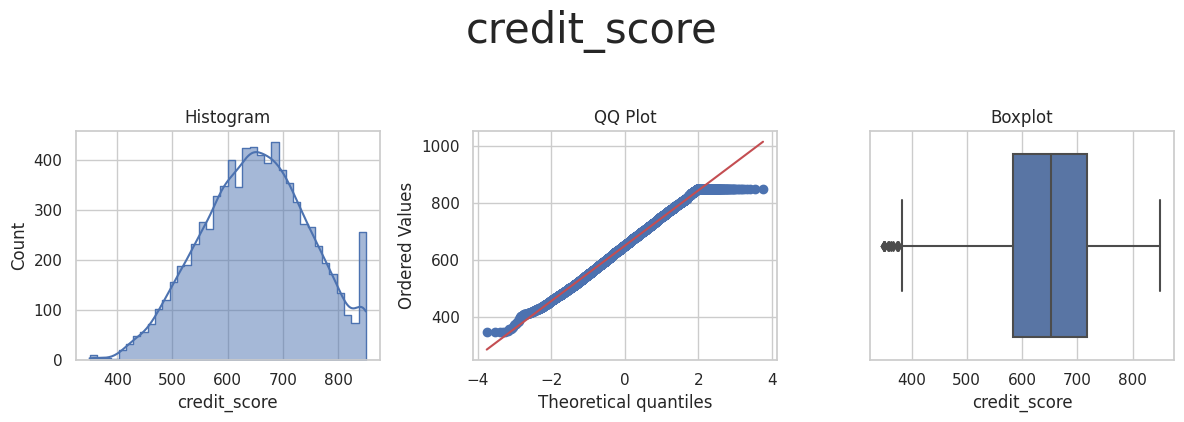

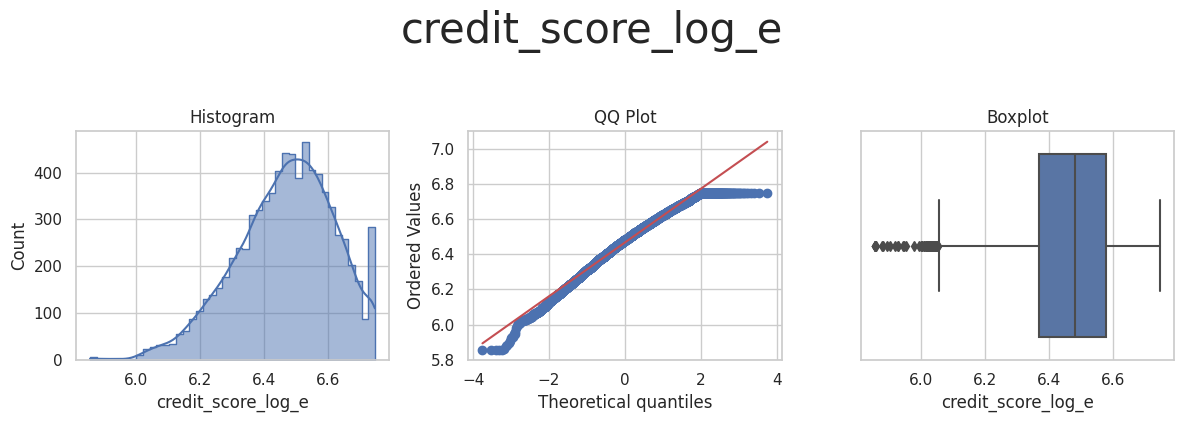

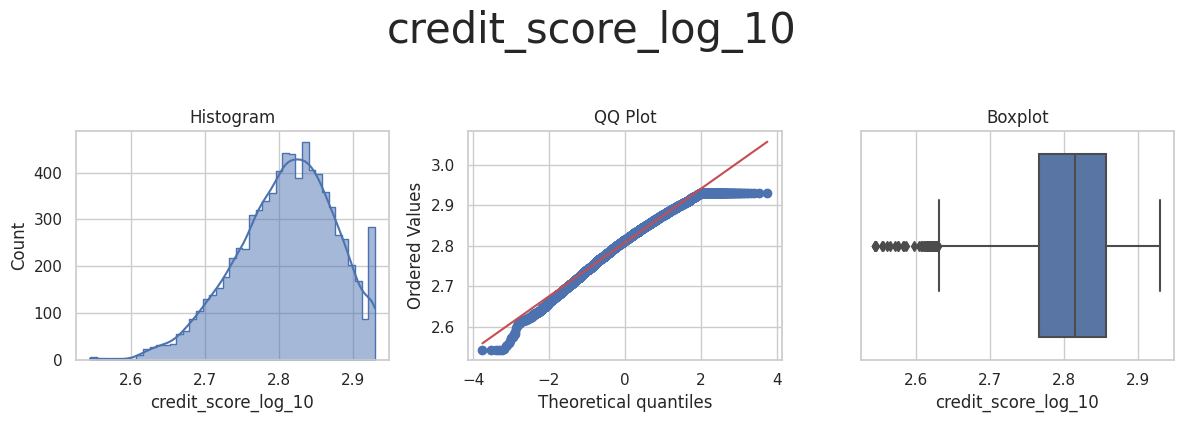

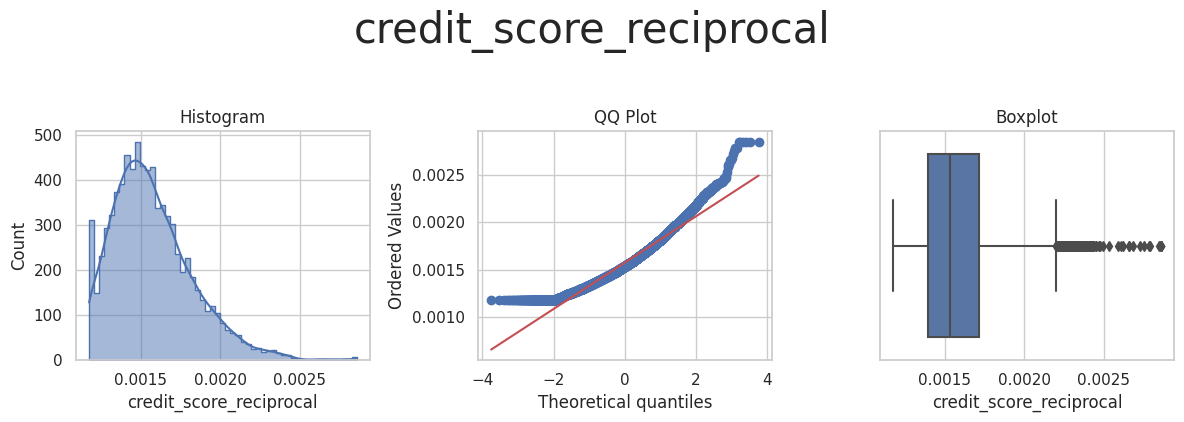

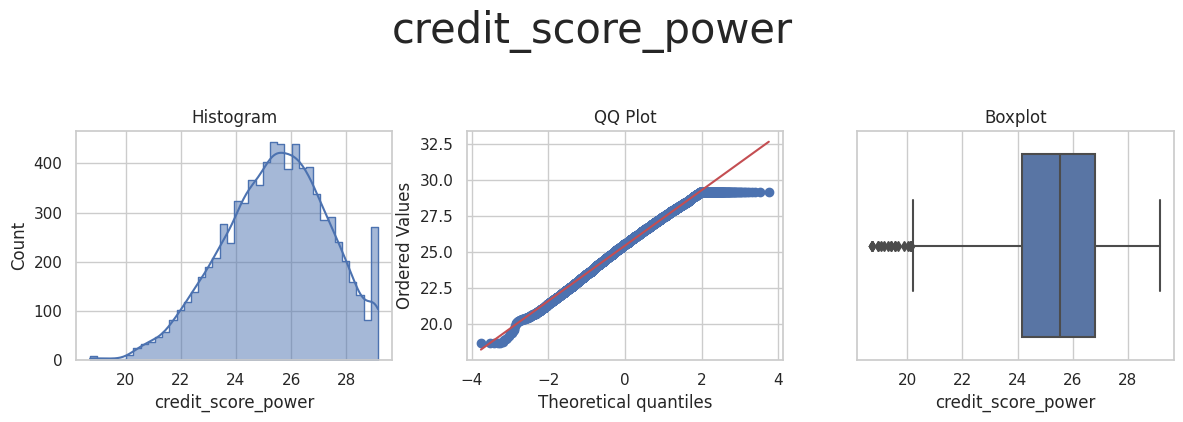

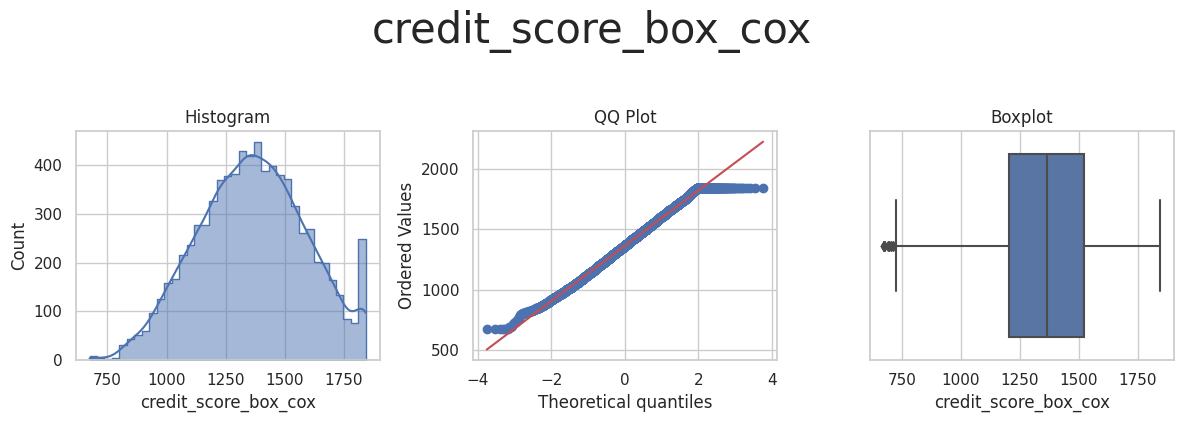

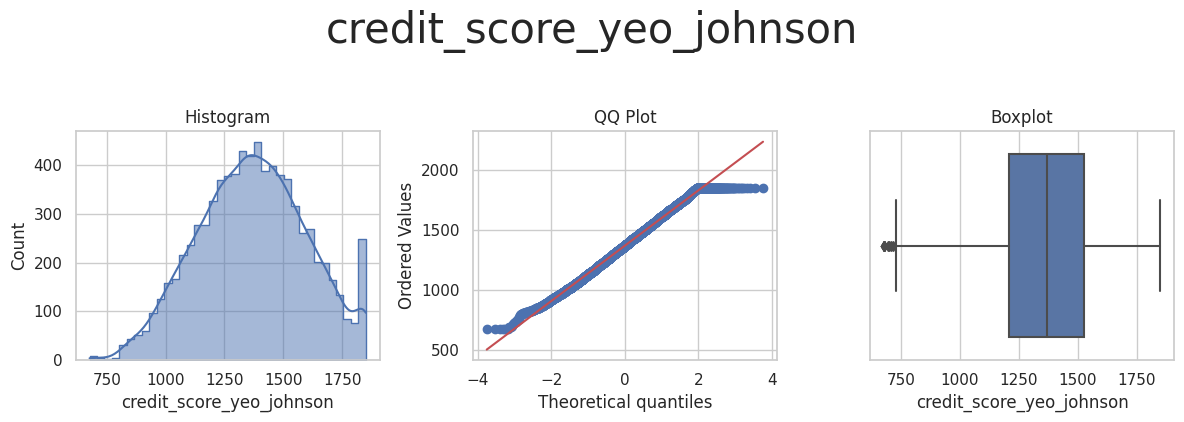



* Variable Analyzed: country
* Applied transformation: ['country_power', 'country_yeo_johnson'] 



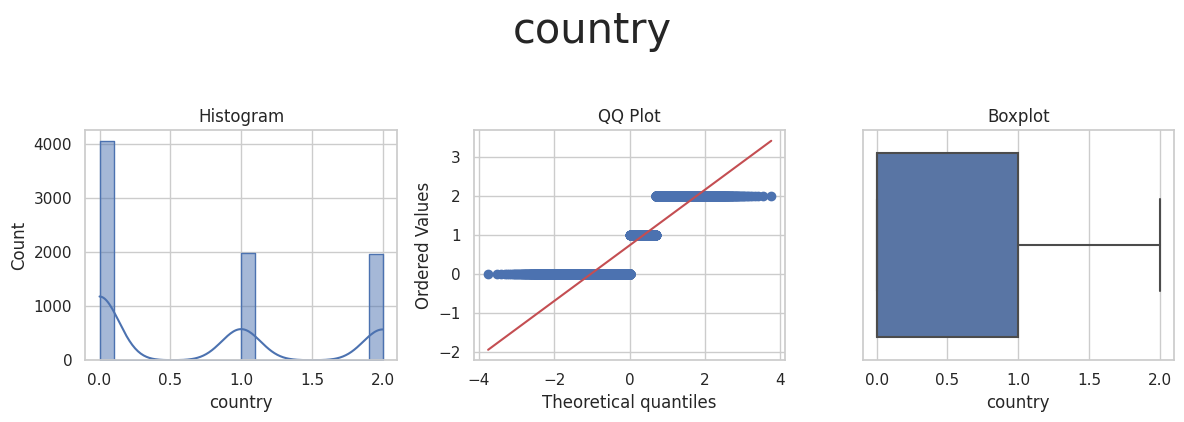

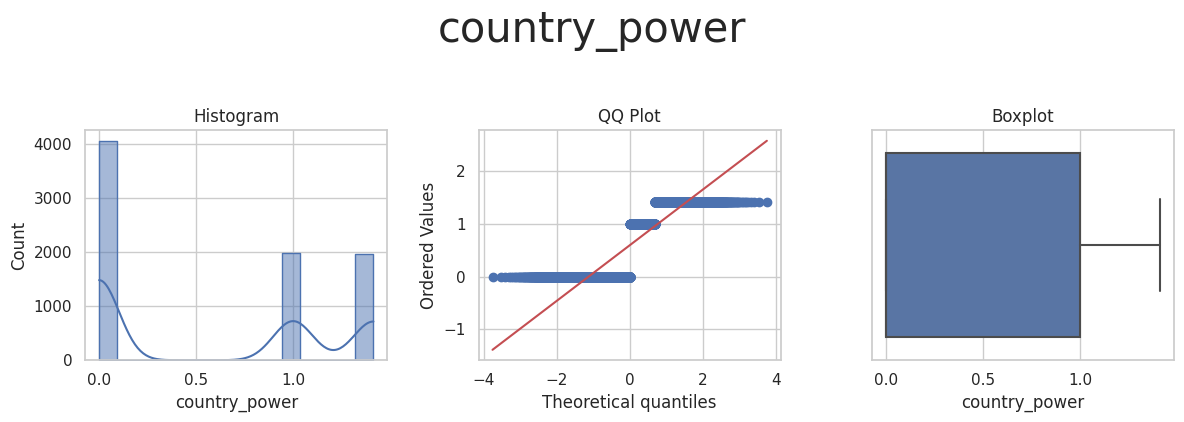

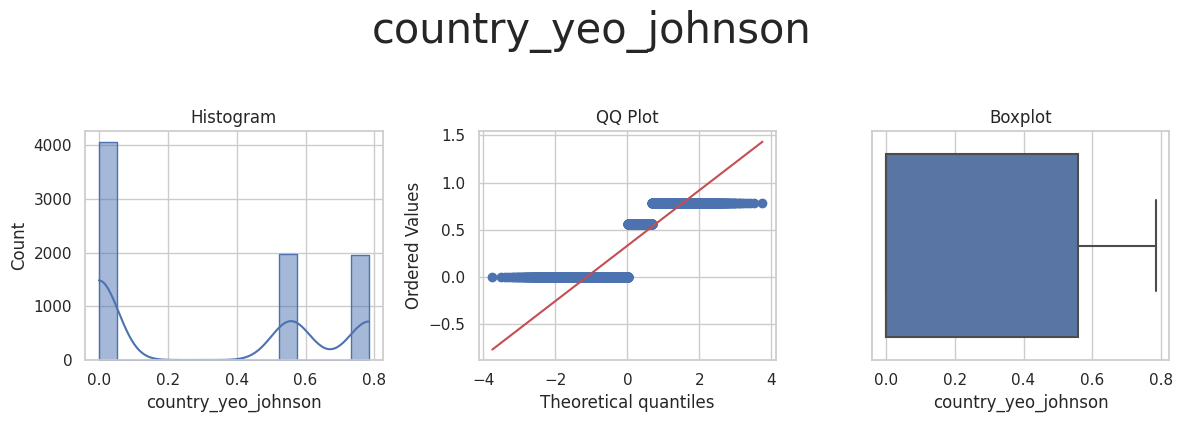



* Variable Analyzed: gender
* Applied transformation: ['gender_power', 'gender_yeo_johnson'] 



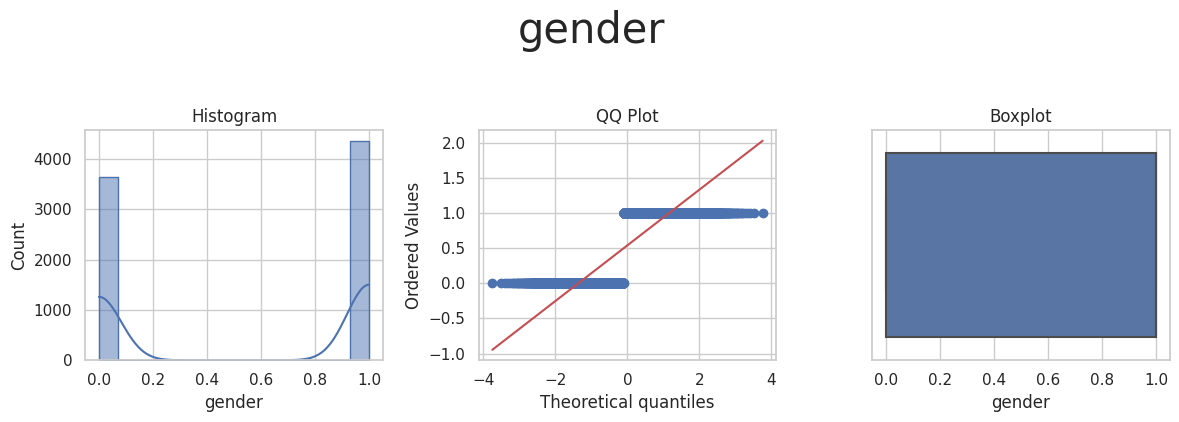

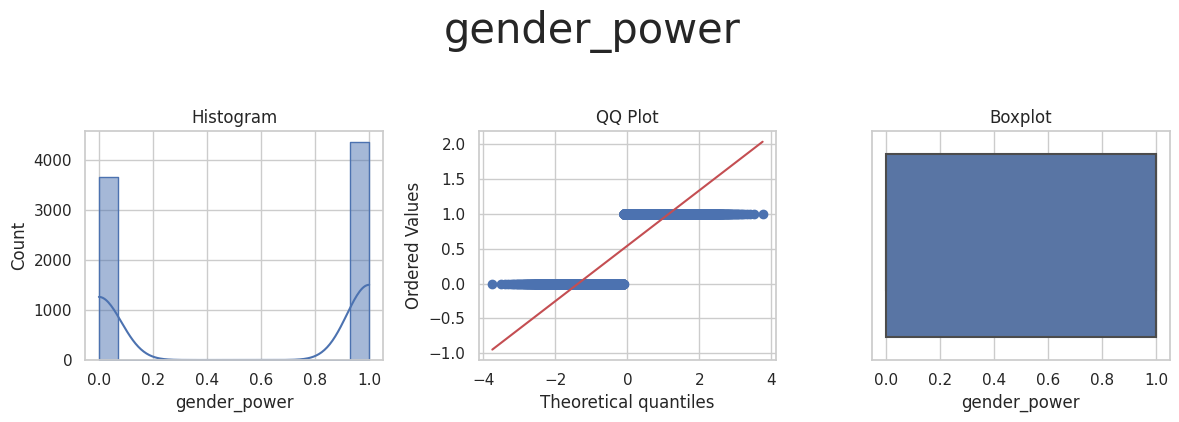

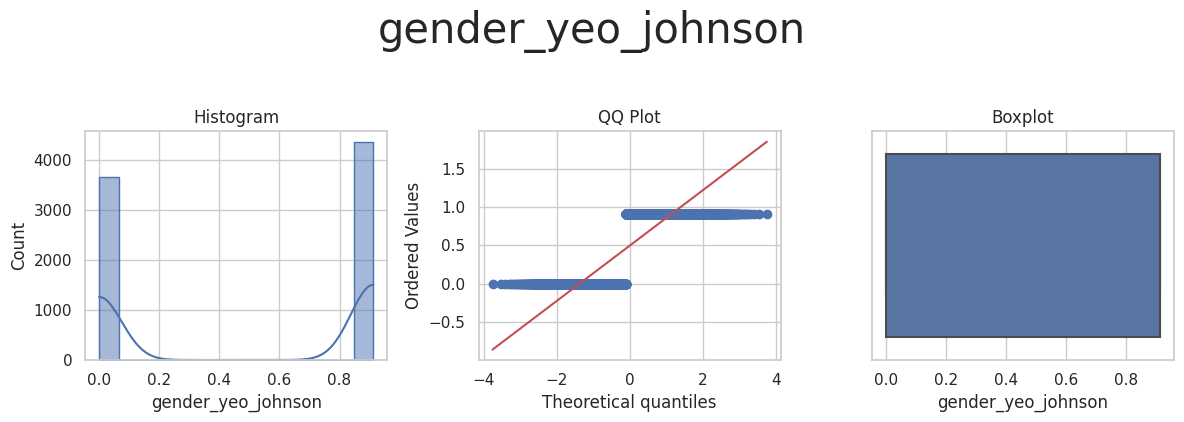



* Variable Analyzed: age
* Applied transformation: ['age_log_e', 'age_log_10', 'age_reciprocal', 'age_power', 'age_box_cox', 'age_yeo_johnson'] 



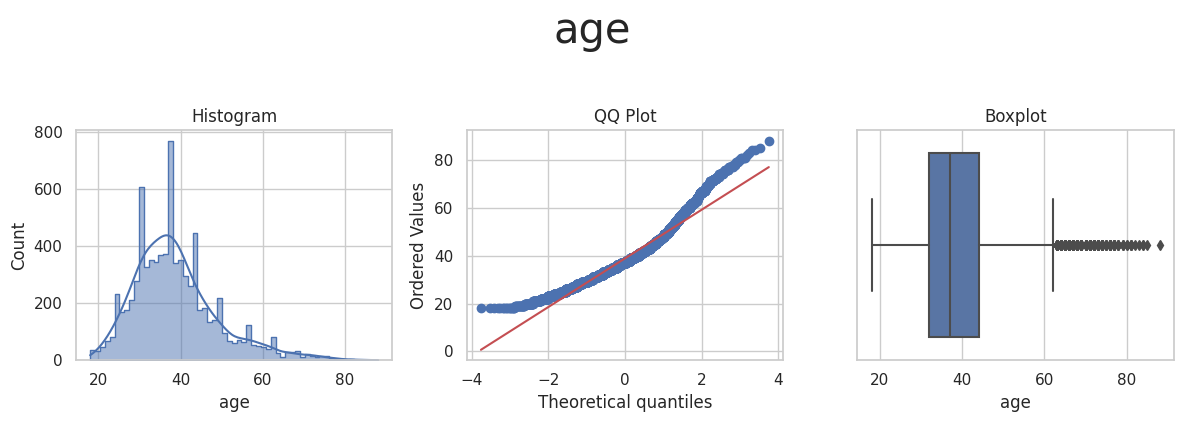

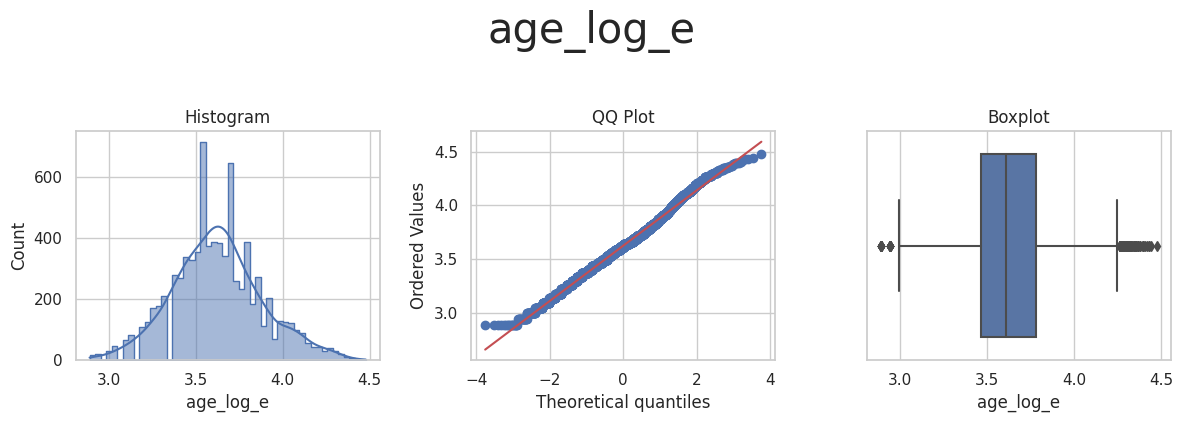

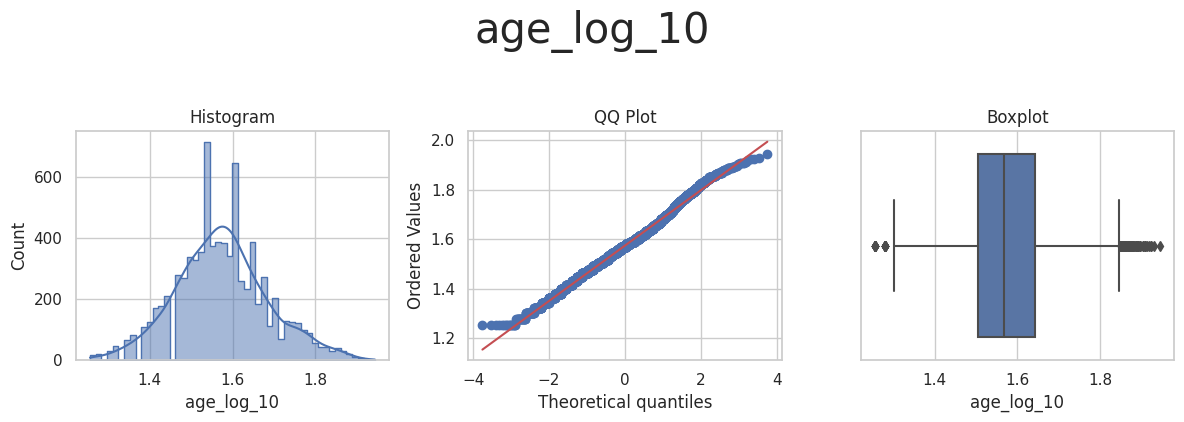

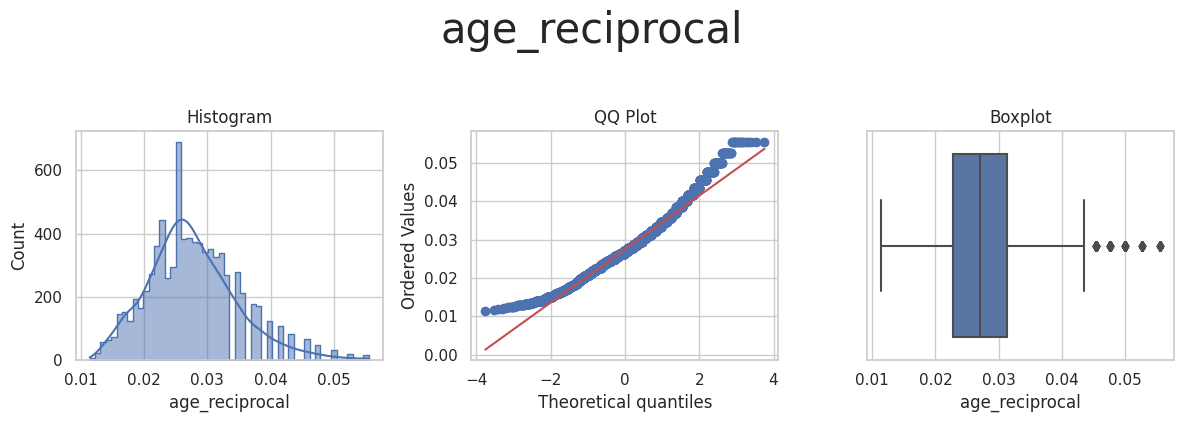

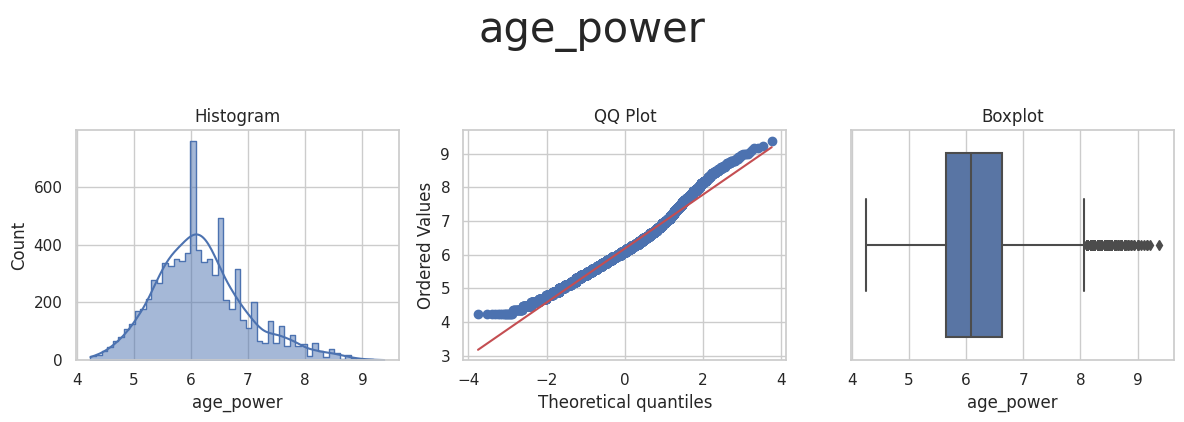

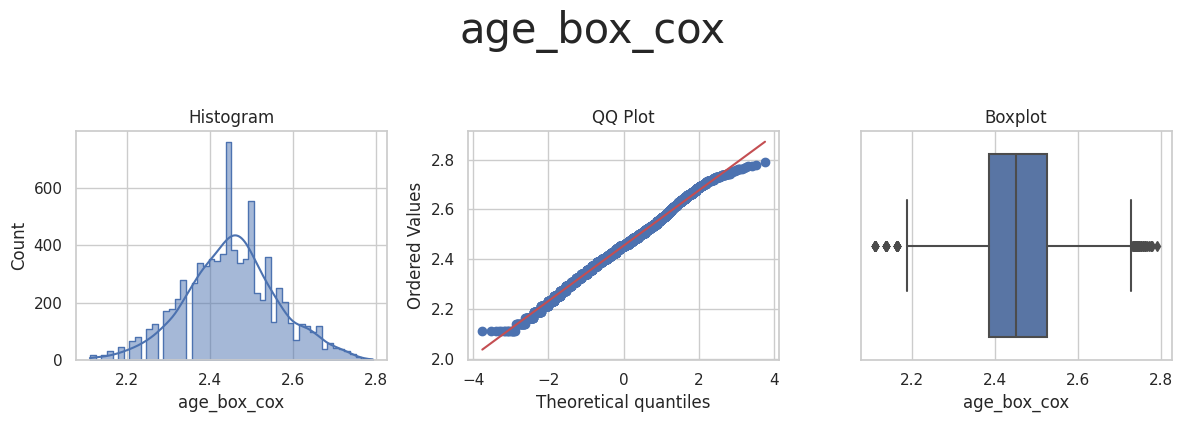

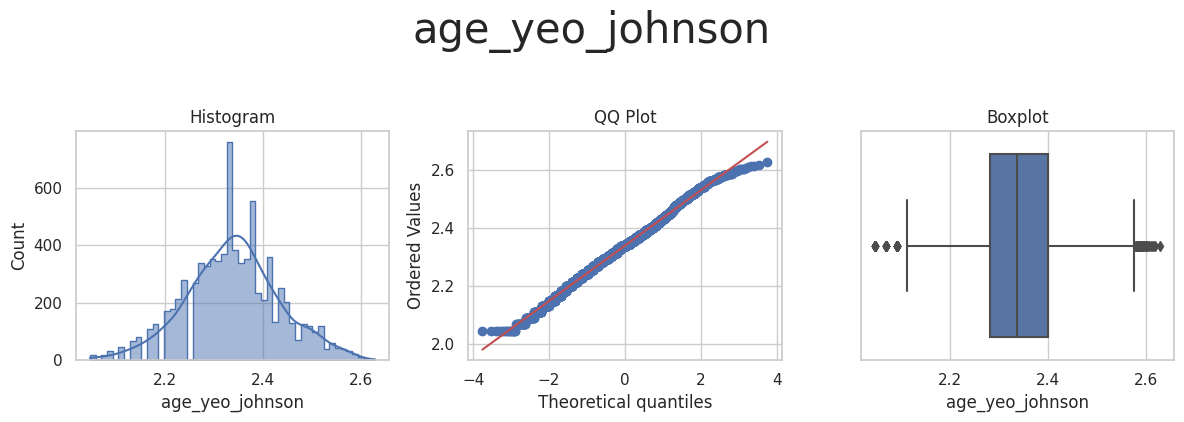



* Variable Analyzed: tenure
* Applied transformation: ['tenure_power', 'tenure_yeo_johnson'] 



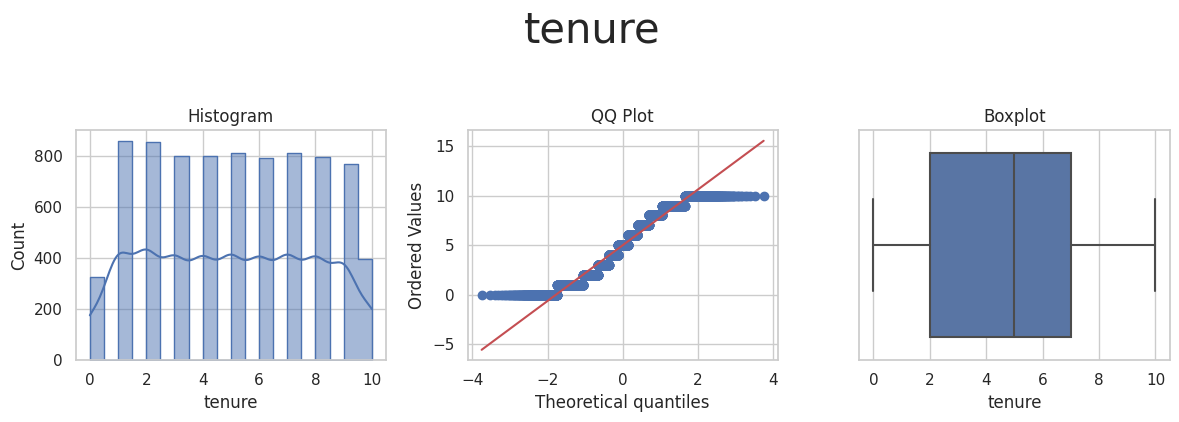

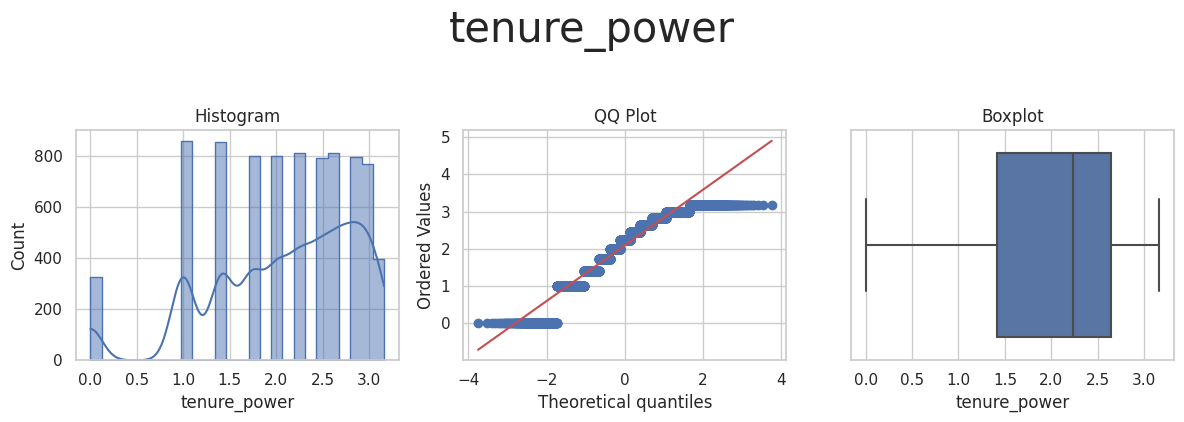

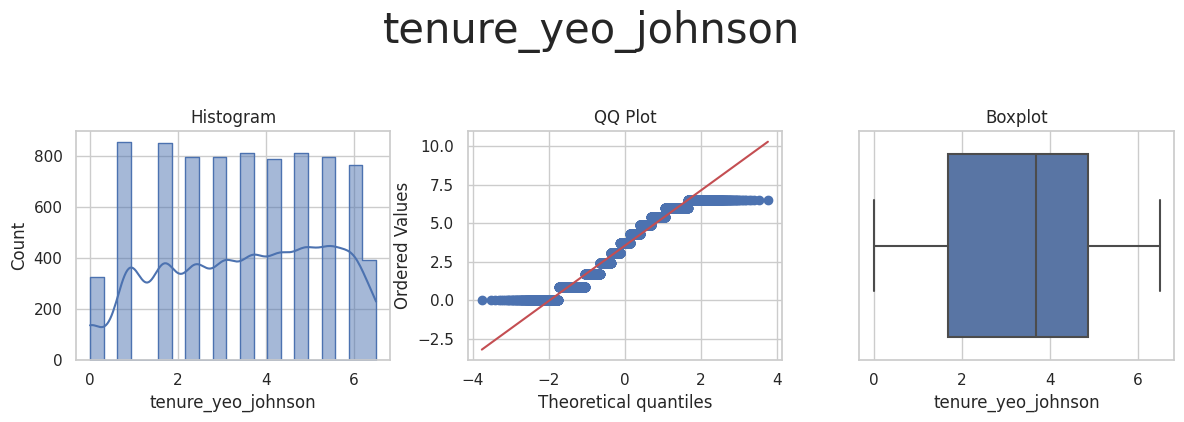



* Variable Analyzed: balance
* Applied transformation: ['balance_power', 'balance_yeo_johnson'] 



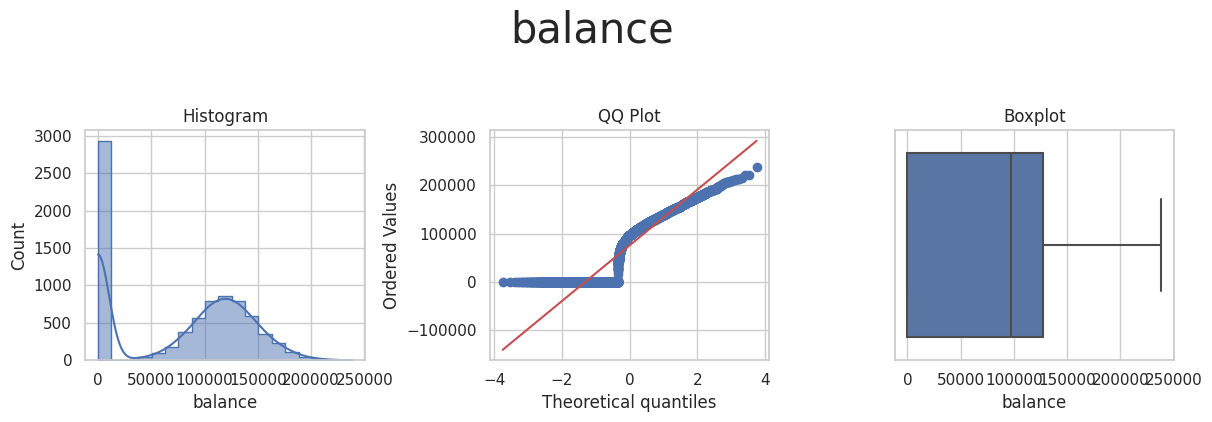

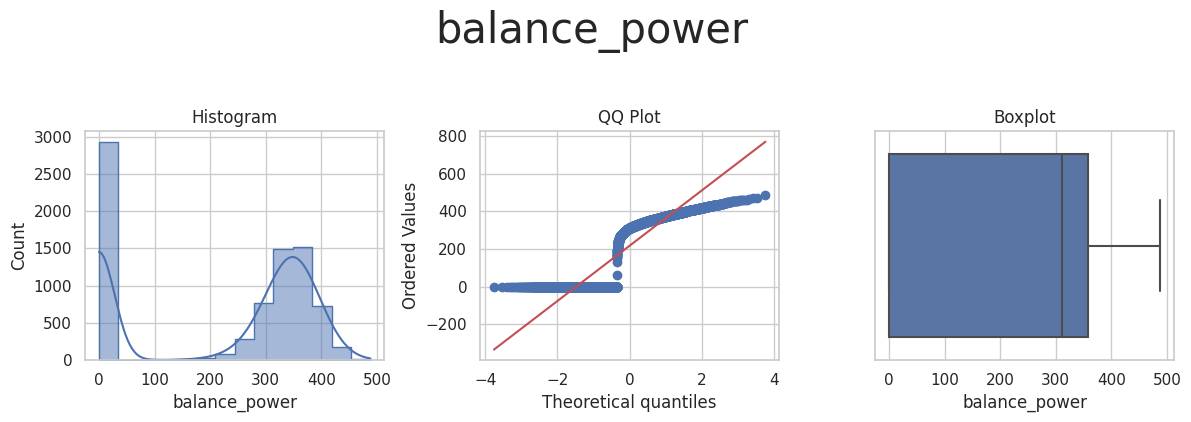

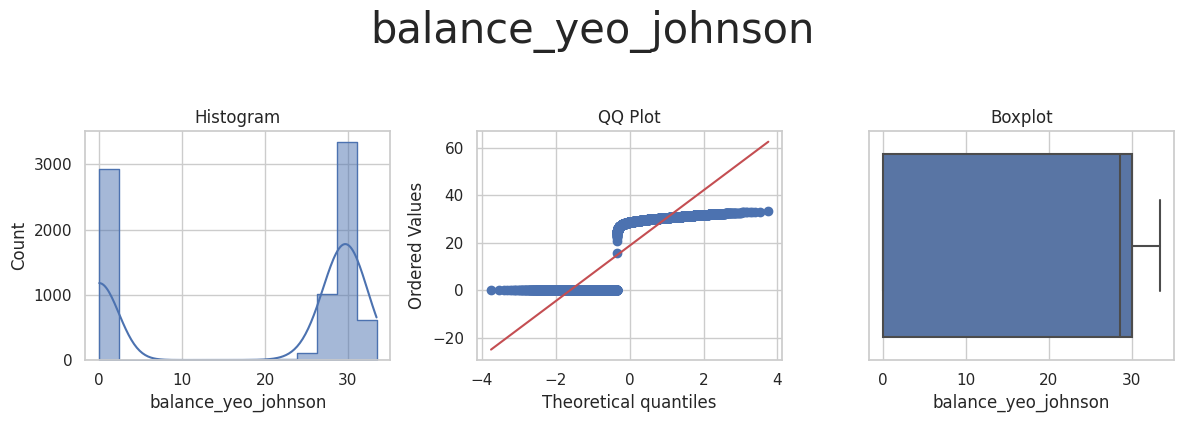



* Variable Analyzed: products_number
* Applied transformation: ['products_number_log_e', 'products_number_log_10', 'products_number_reciprocal', 'products_number_power', 'products_number_box_cox', 'products_number_yeo_johnson'] 



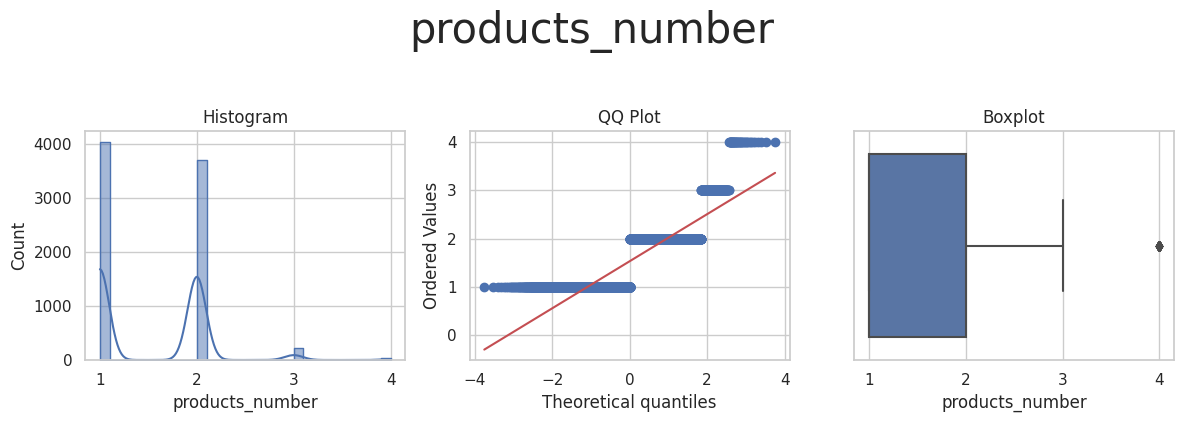

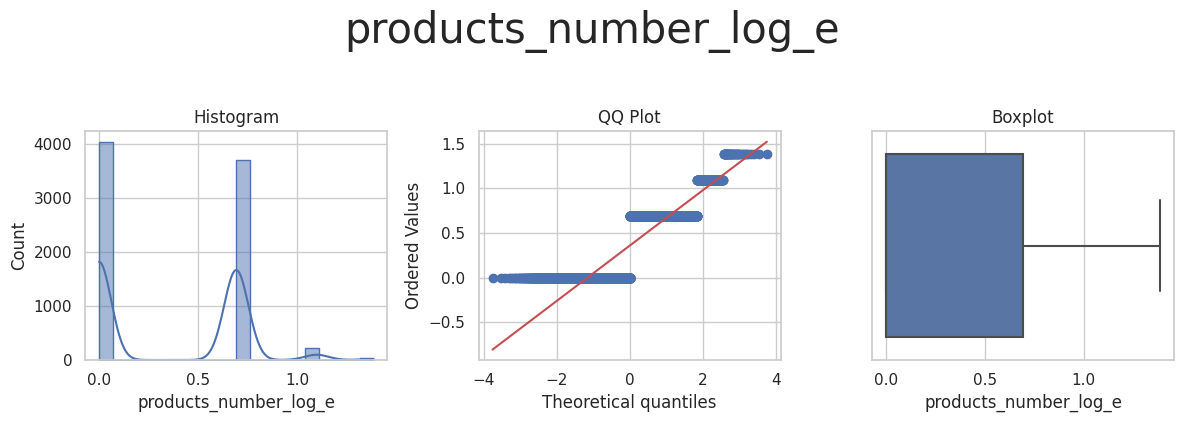

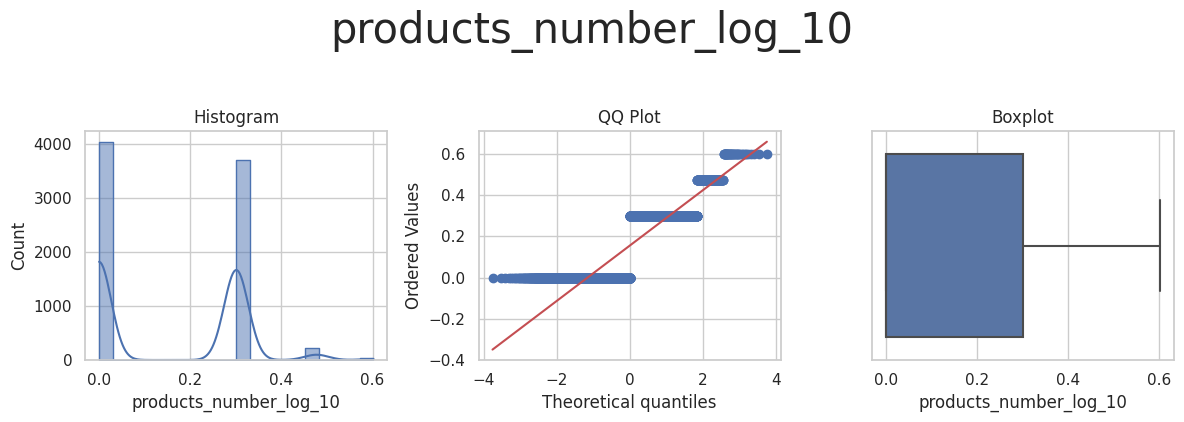

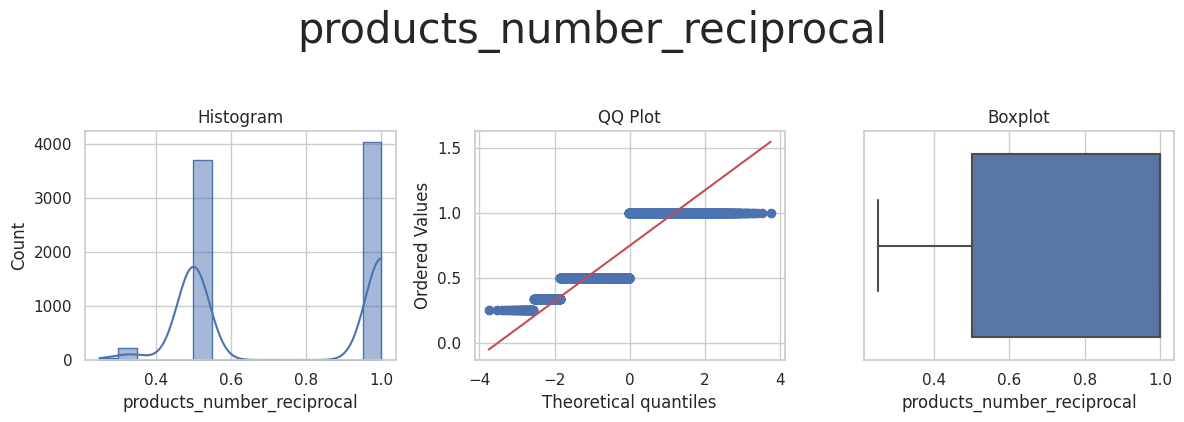

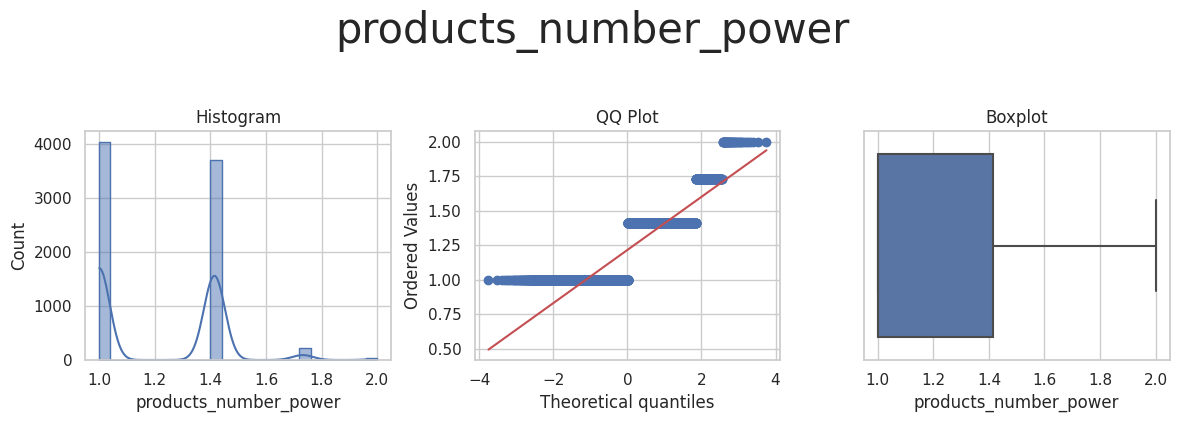

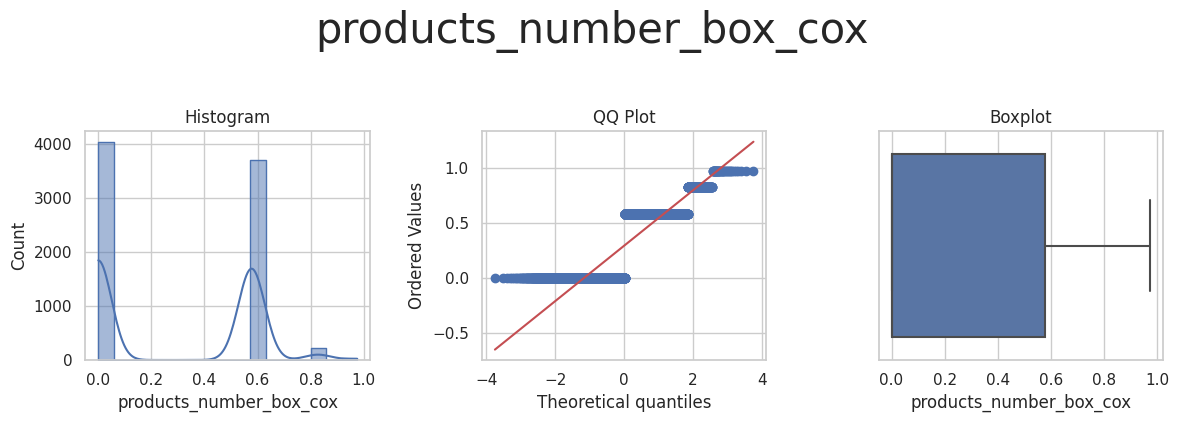

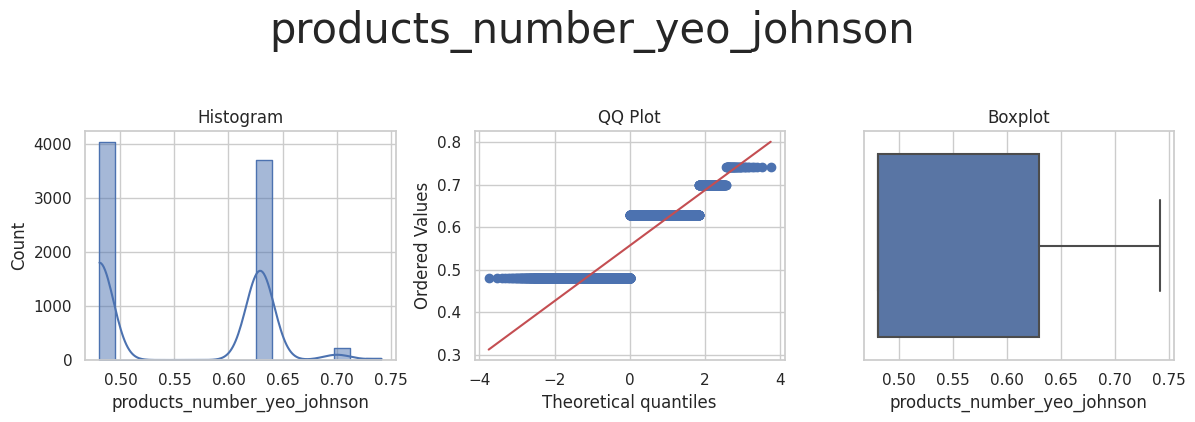



* Variable Analyzed: credit_card
* Applied transformation: ['credit_card_power', 'credit_card_yeo_johnson'] 



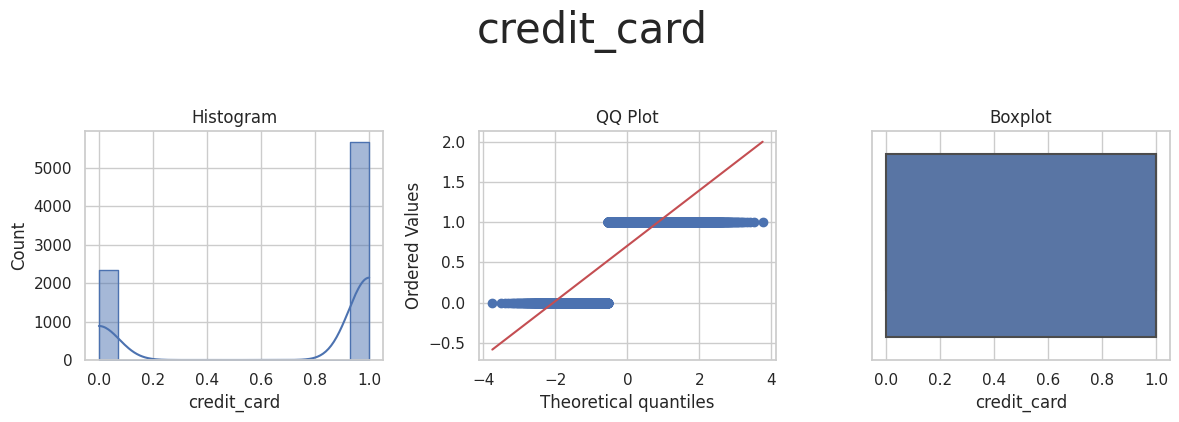

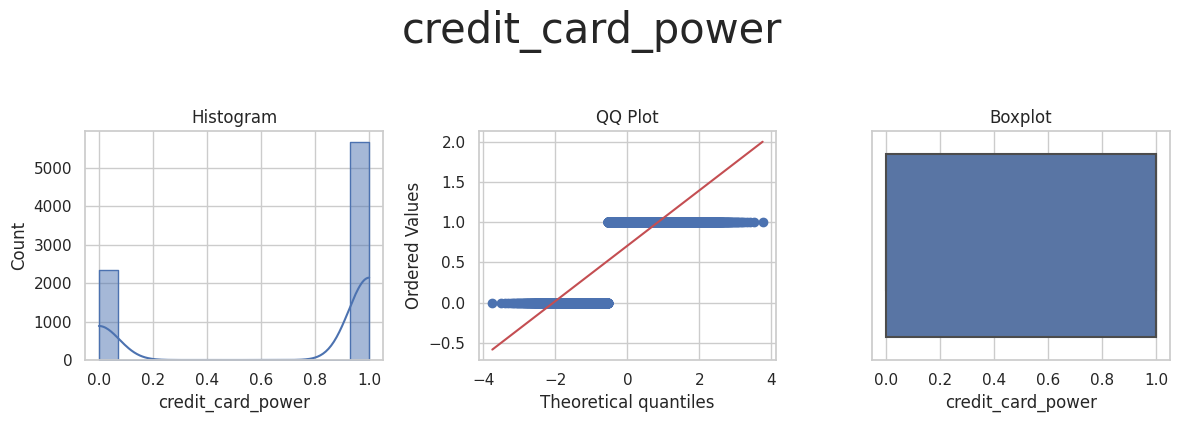

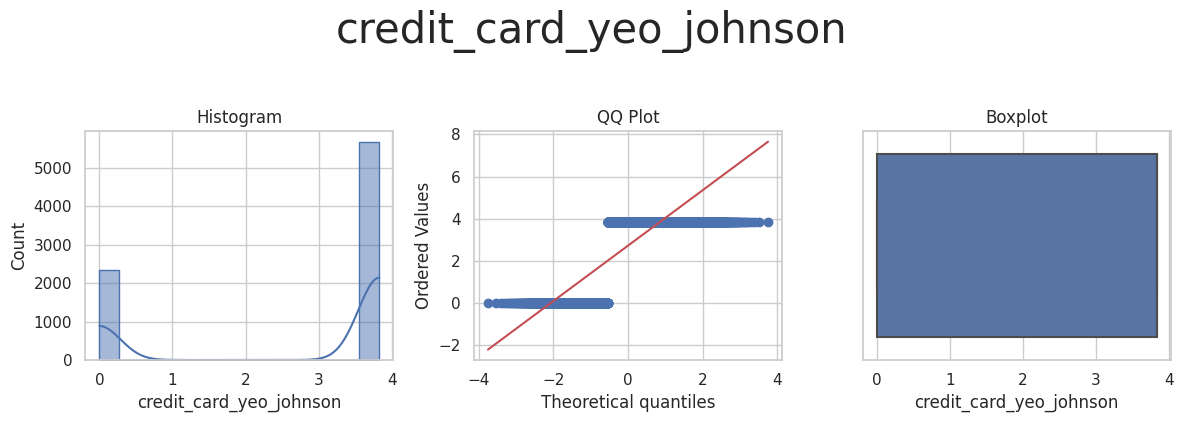



* Variable Analyzed: active_member
* Applied transformation: ['active_member_power', 'active_member_yeo_johnson'] 



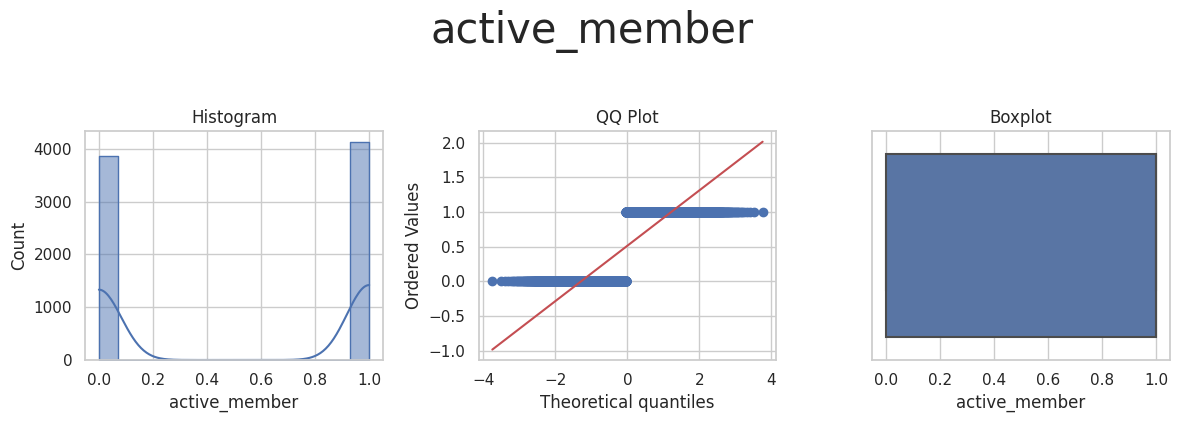

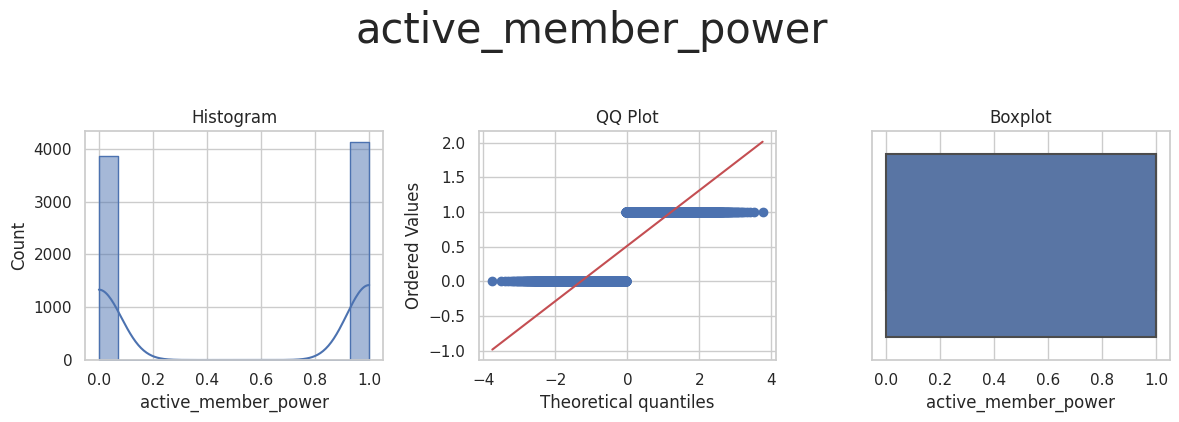

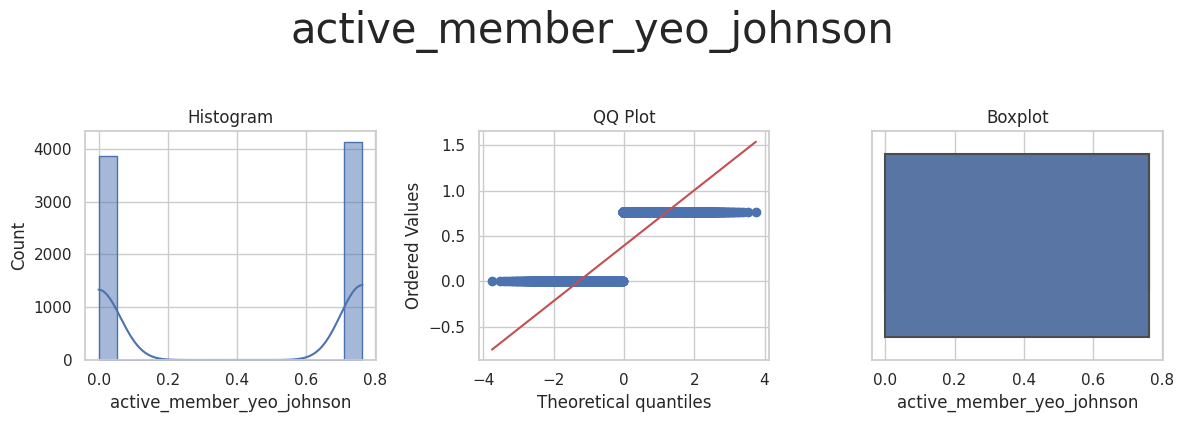



* Variable Analyzed: estimated_salary
* Applied transformation: ['estimated_salary_log_e', 'estimated_salary_log_10', 'estimated_salary_reciprocal', 'estimated_salary_power', 'estimated_salary_box_cox', 'estimated_salary_yeo_johnson'] 



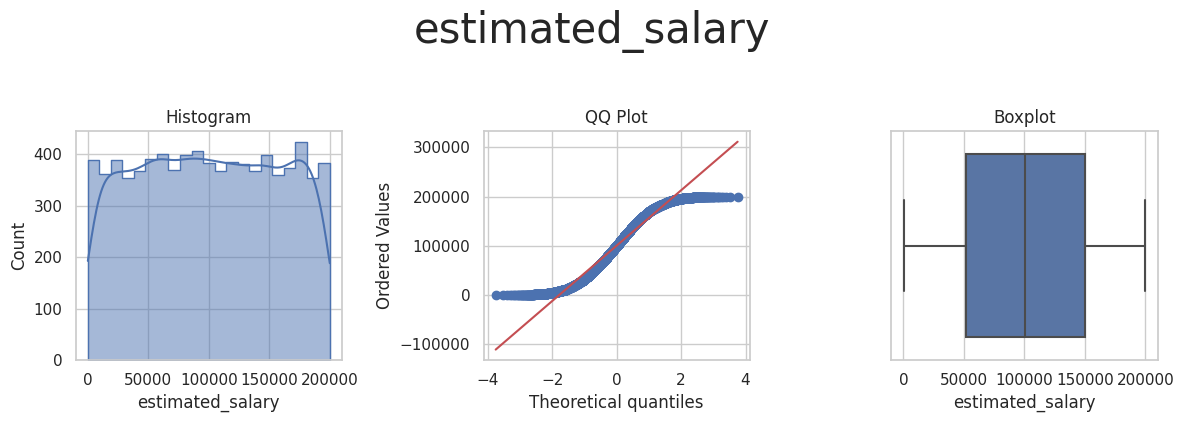

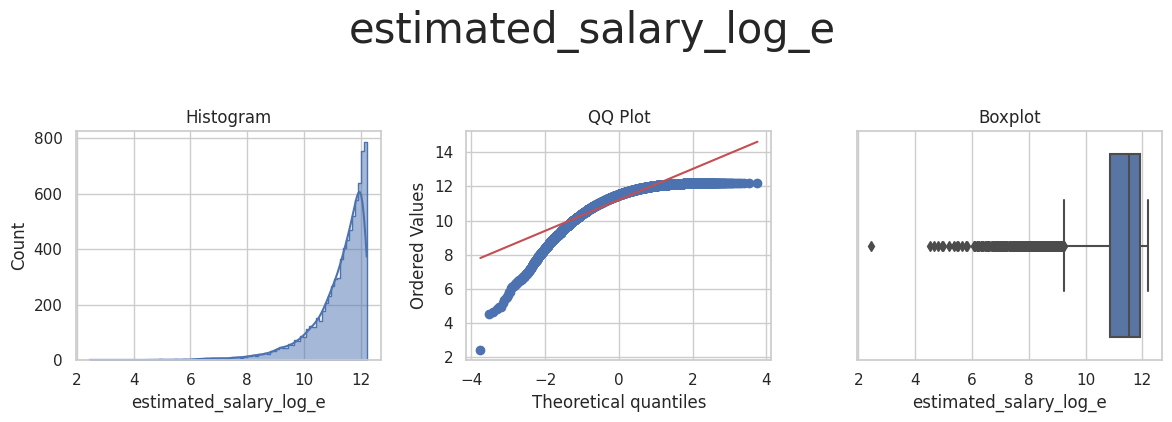

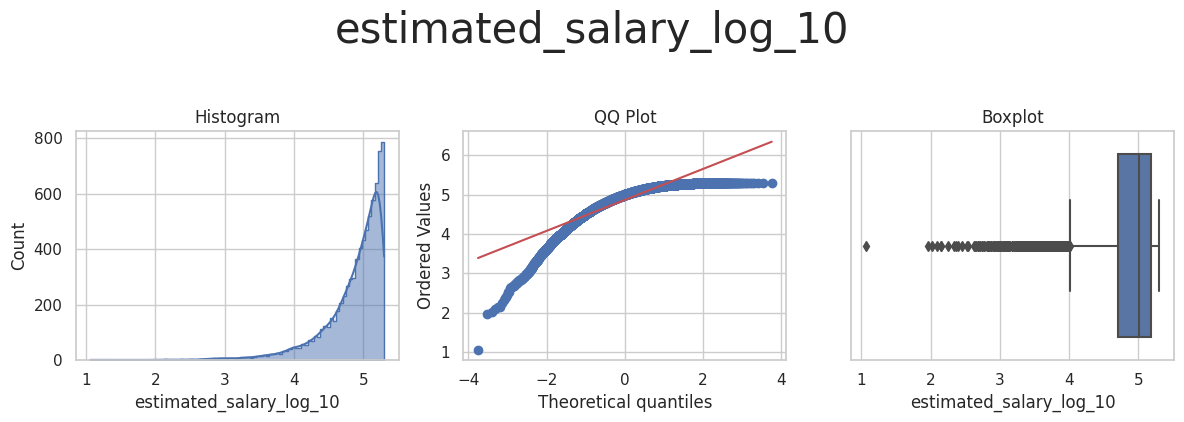

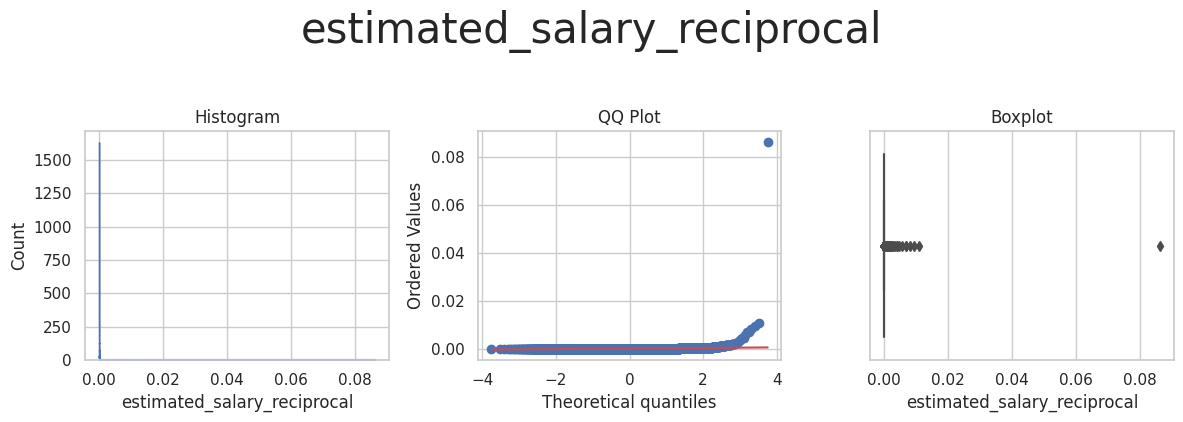

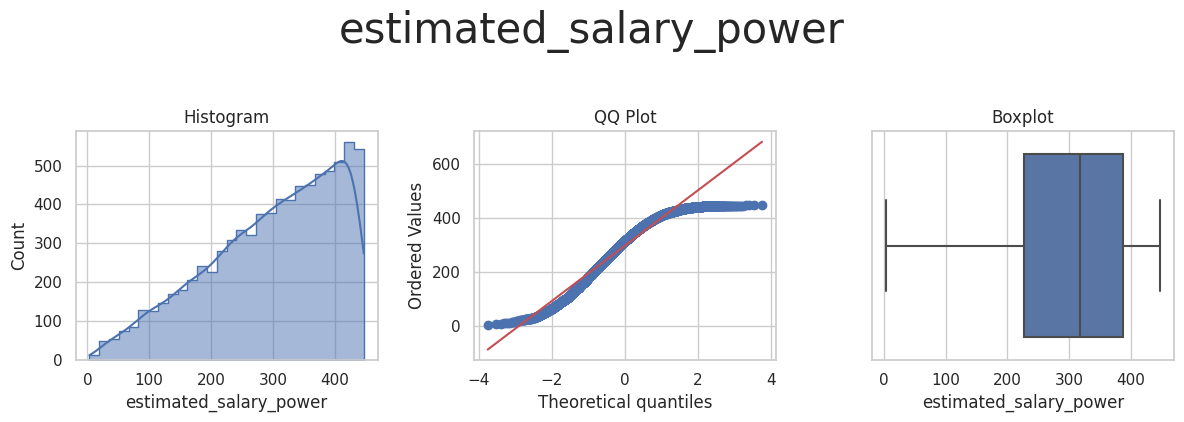

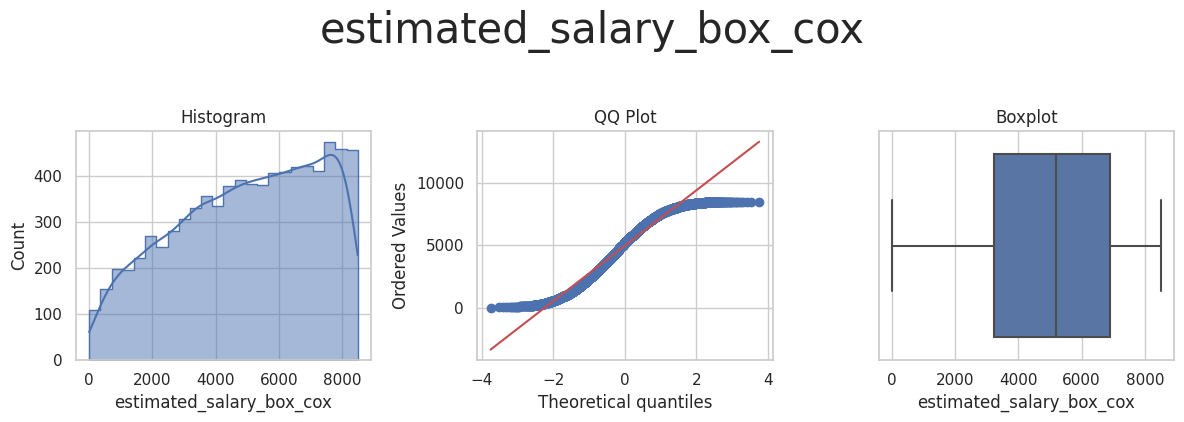

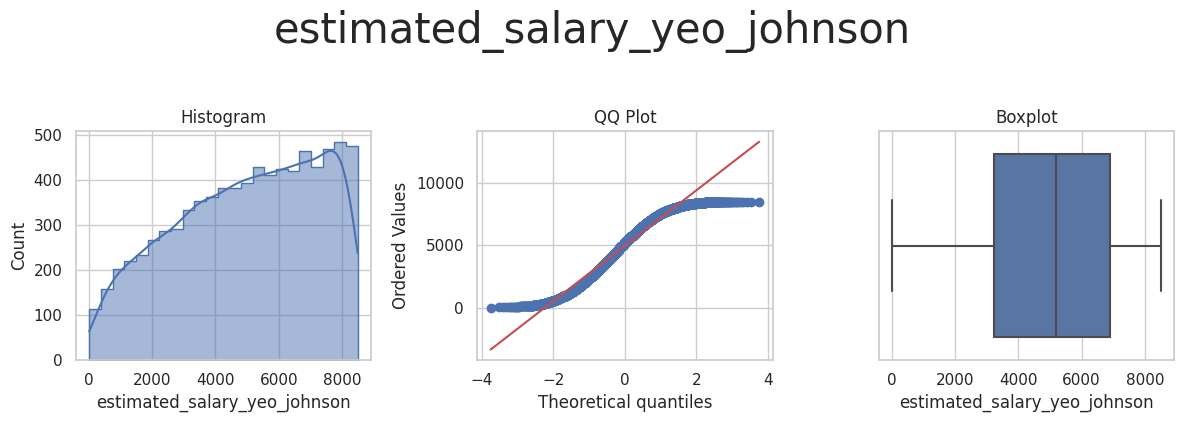

In [10]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

Assessed variables distribution to select the most suitable method
* Conclusion - Only age has been transform with log_e to have a normal distribution and have been selected for this transformation.

## Selected Transformers * 
Log Transformer (base e )

In [11]:
# Selected variables for LogTransformer
vars_engineering_log = ['age']
vars_engineering_log

['age']

In [12]:
# Apply the selected transformation to the Train and Test set
transformed_var = vt.LogTransformer(variables=vars_engineering_log)
TrainSet = transformed_var.fit_transform(TrainSet)
TestSet = transformed_var.transform(TestSet)

## Outlier Transformation
We apply all numerical variables except the target

In [13]:
variables_engineering = (TrainSet.select_dtypes(include=['float', 'int']).columns.to_list())
variables_engineering.remove('churn')
variables_engineering

['credit_score',
 'country',
 'gender',
 'age',
 'tenure',
 'balance',
 'products_number',
 'credit_card',
 'active_member',
 'estimated_salary']

In [14]:
# Create a DataFrame, with the variables
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(5)

credit_score  country  gender       age  tenure    balance  \
0           667        1       0  3.526361       5       0.00   
1           427        2       1  3.737670       1   75681.52   
2           535        0       0  3.367296       2  112367.34   
3           654        1       1  3.688879       5  105683.63   
4           850        1       0  4.043051       8  126776.30   

   products_number  credit_card  active_member  estimated_salary  
0                2            1              0         163830.64  
1                1            1              1          57098.00  
2                1            1              0         185630.76  
3                1            1              0         173617.09  
4                2            1              1         132298.49

* Create the engineered variables and apply the transformations, assess the engineered variables distribution and select the most suitable method for each variable.
* Variable transformation distribution analysis - Assess variables distribution to select the most suitable methodd:

* Variable Analyzed: credit_score
* Applied transformation: ['credit_score_iqr'] 



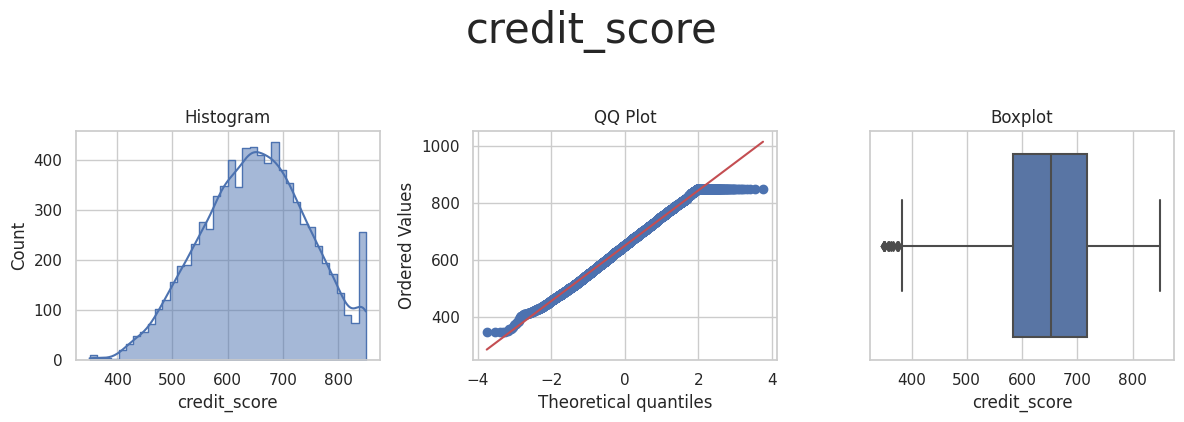

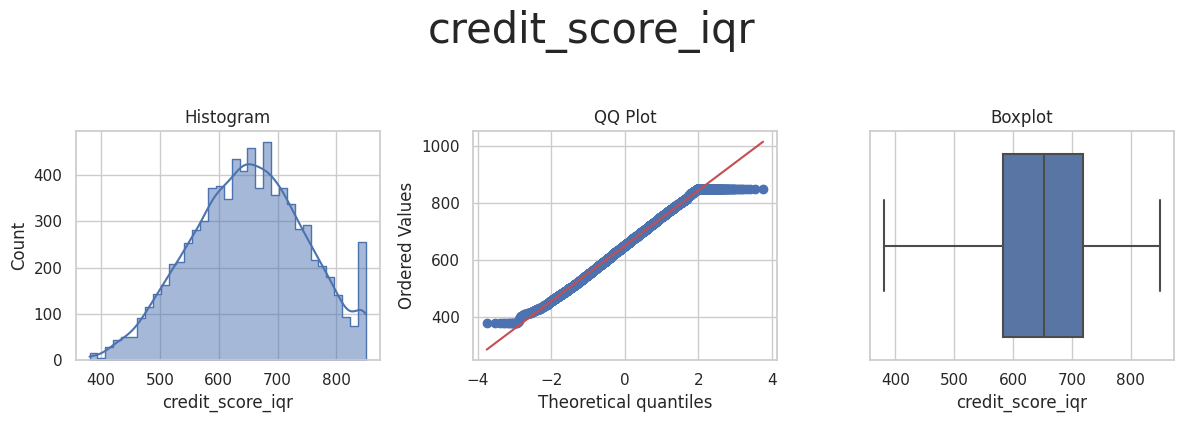



* Variable Analyzed: country
* Applied transformation: ['country_iqr'] 



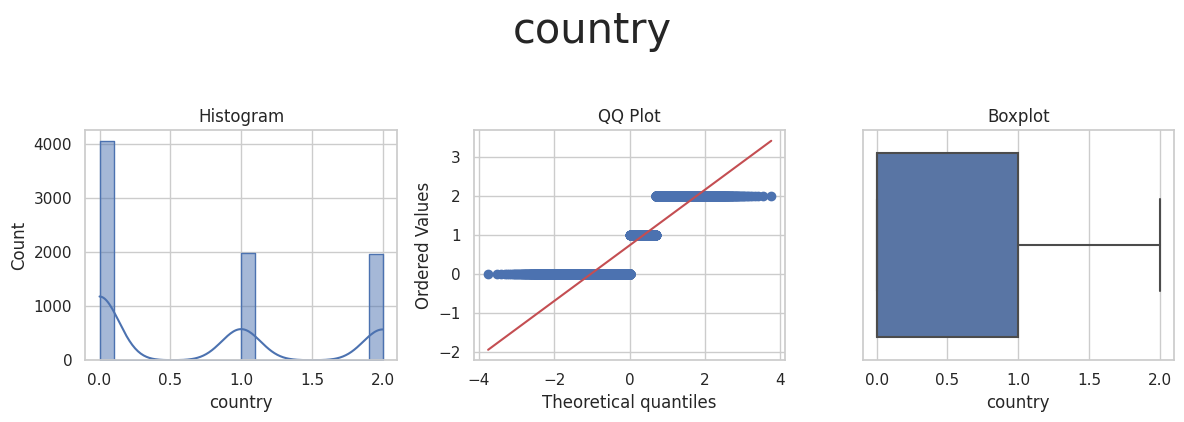

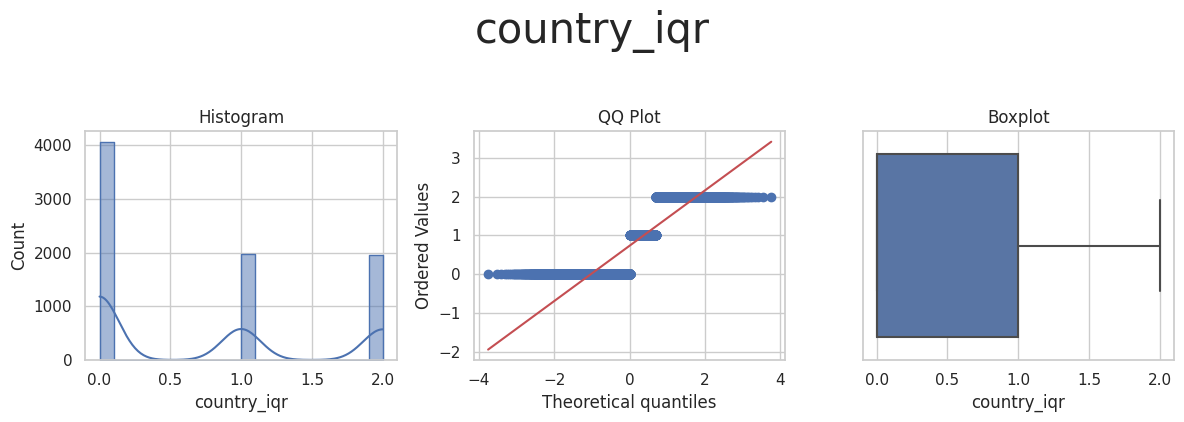



* Variable Analyzed: gender
* Applied transformation: ['gender_iqr'] 



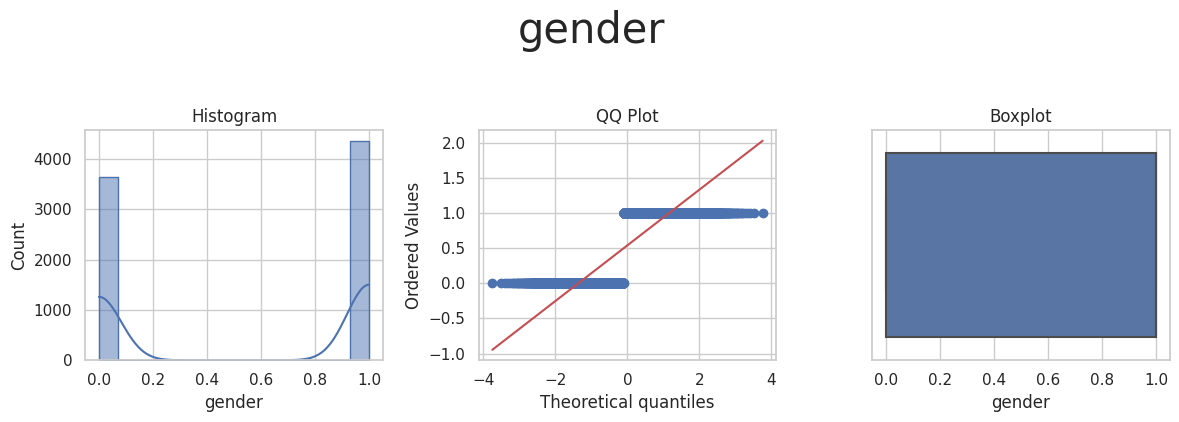

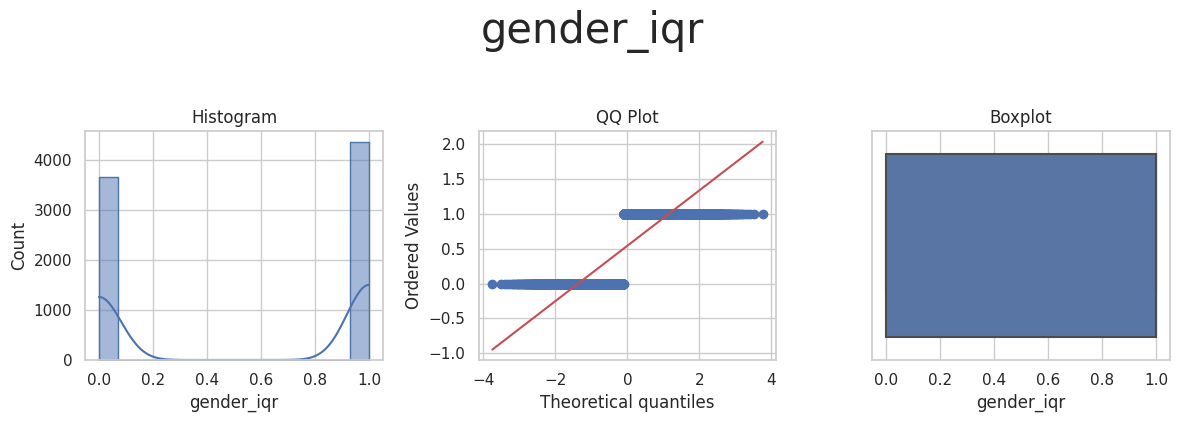



* Variable Analyzed: age
* Applied transformation: ['age_iqr'] 



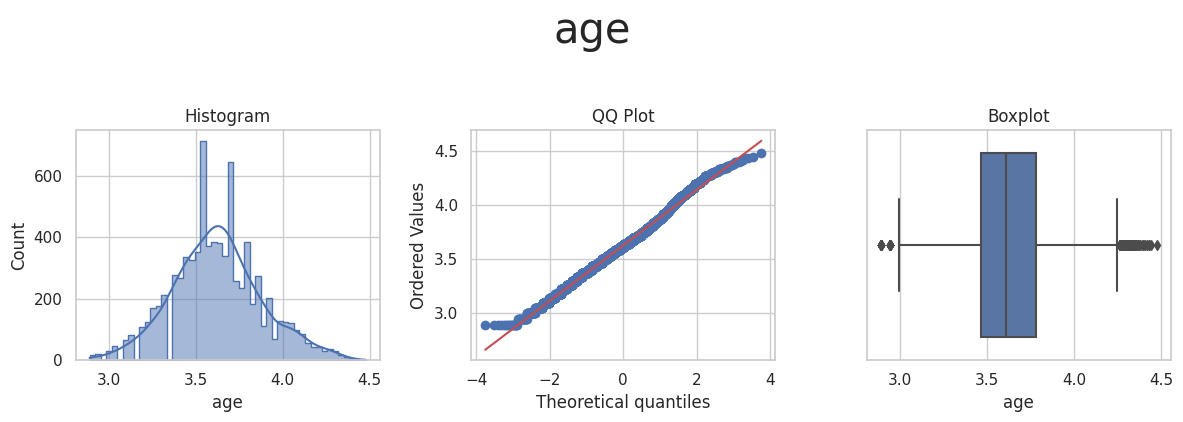

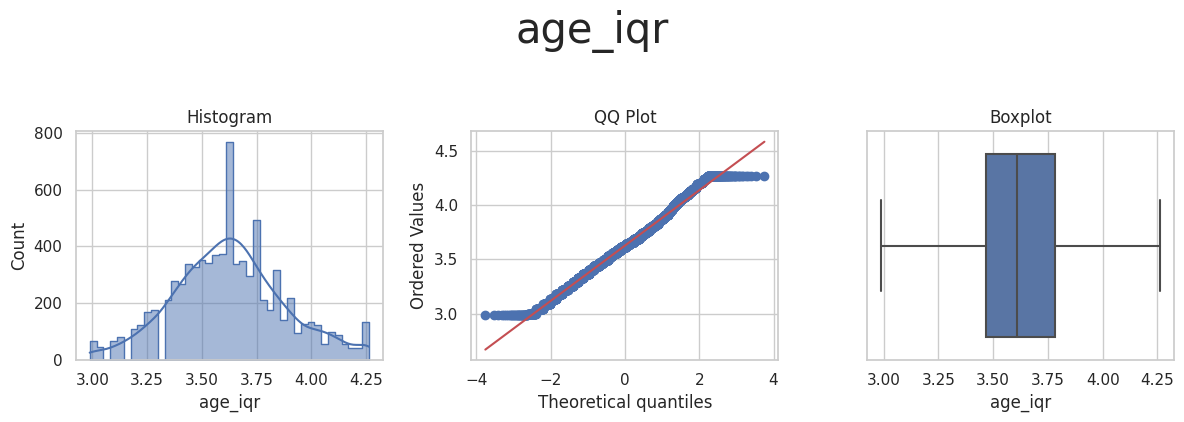



* Variable Analyzed: tenure
* Applied transformation: ['tenure_iqr'] 



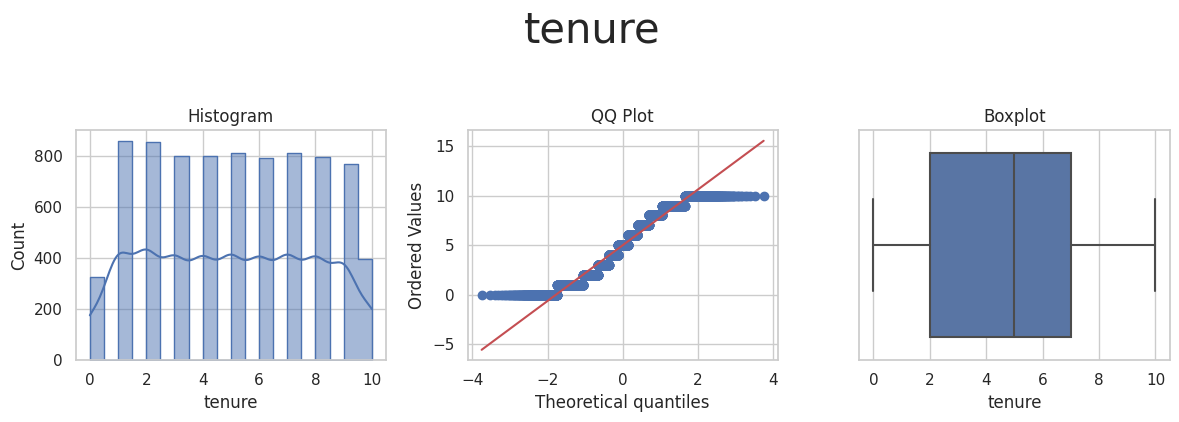

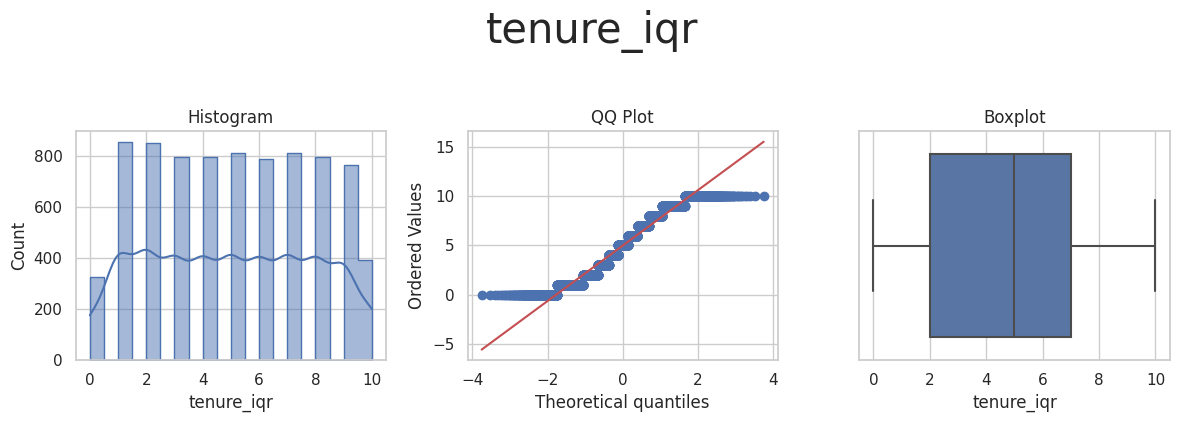



* Variable Analyzed: balance
* Applied transformation: ['balance_iqr'] 



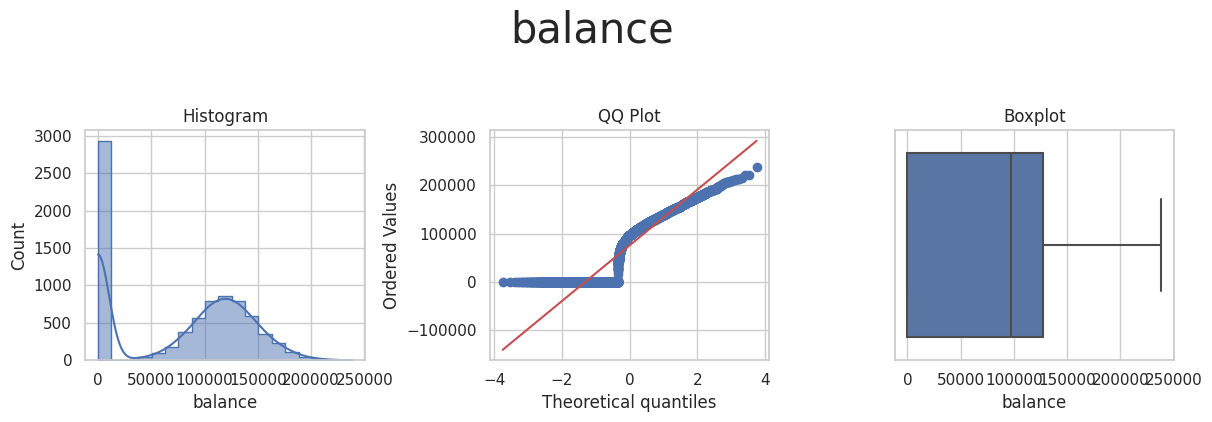

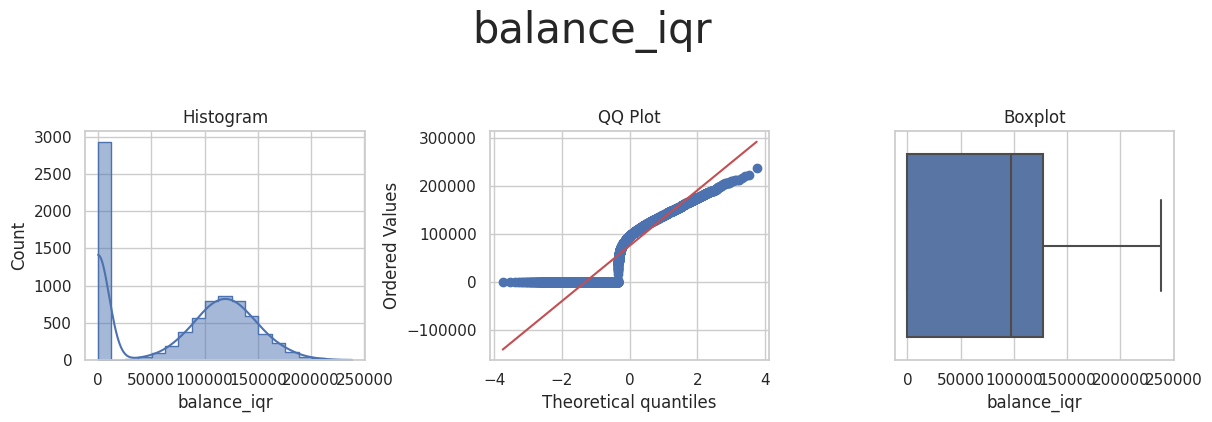



* Variable Analyzed: products_number
* Applied transformation: ['products_number_iqr'] 



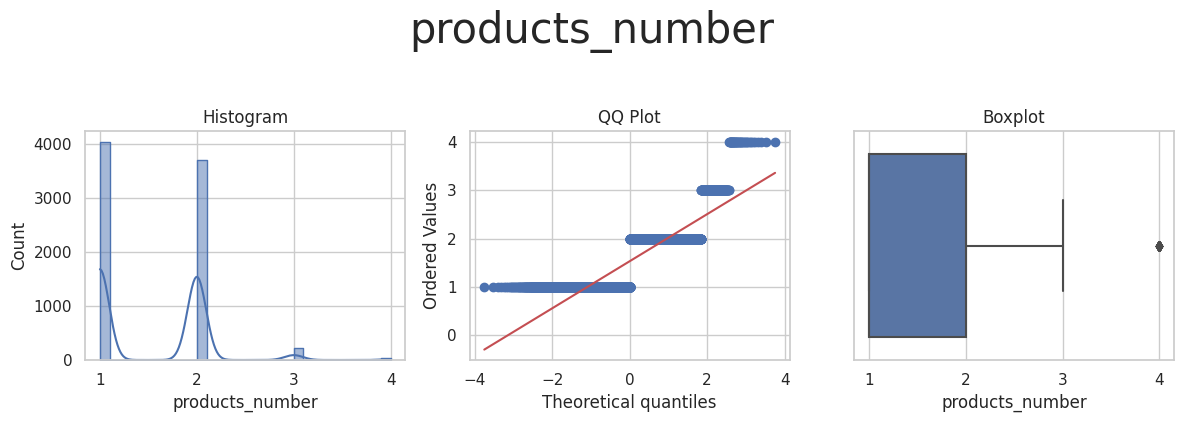

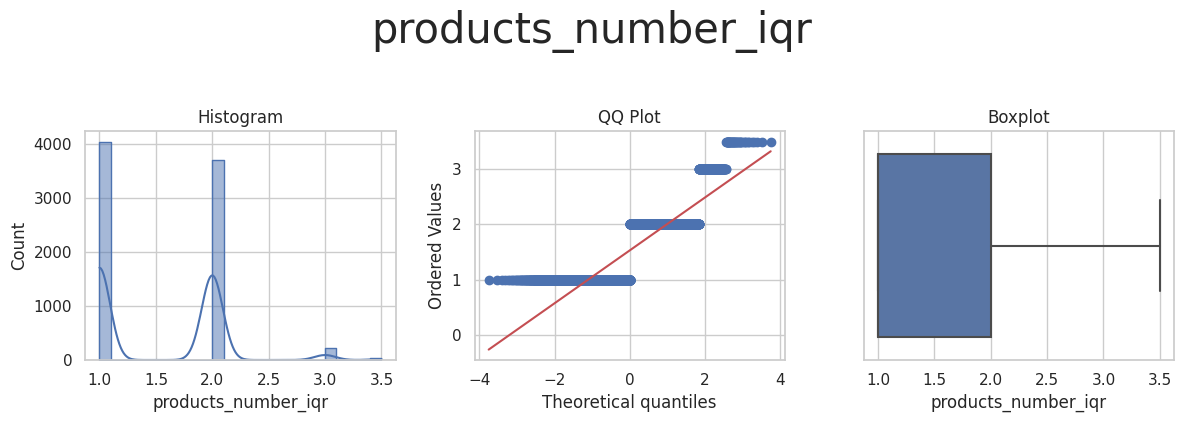



* Variable Analyzed: credit_card
* Applied transformation: ['credit_card_iqr'] 



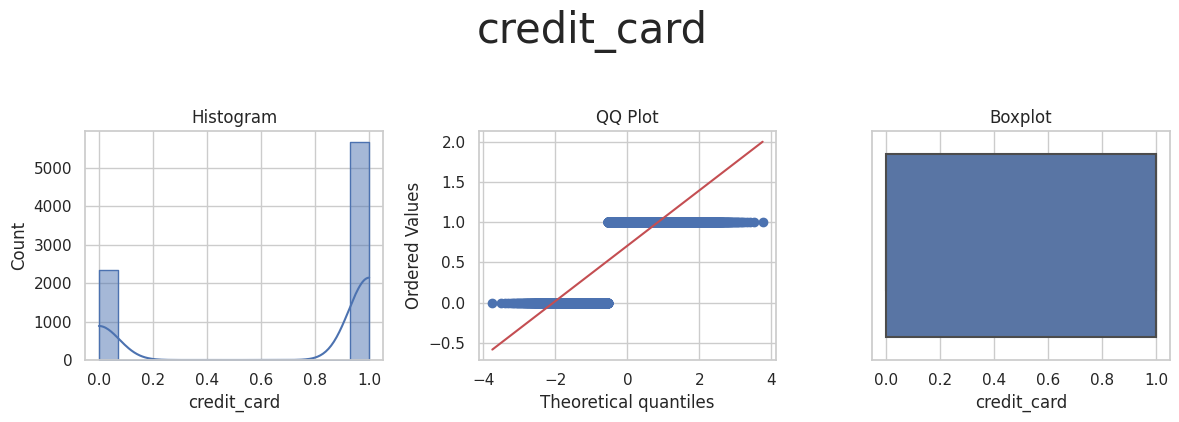

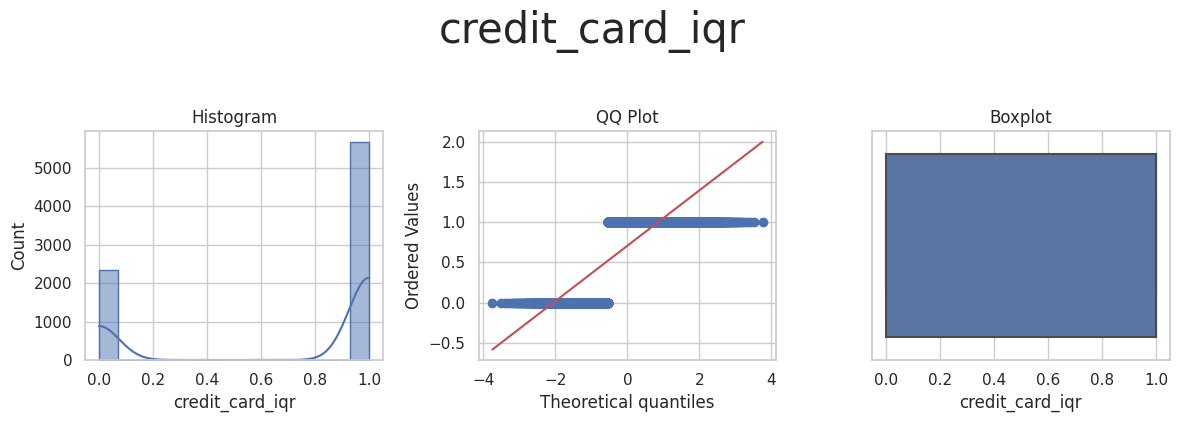



* Variable Analyzed: active_member
* Applied transformation: ['active_member_iqr'] 



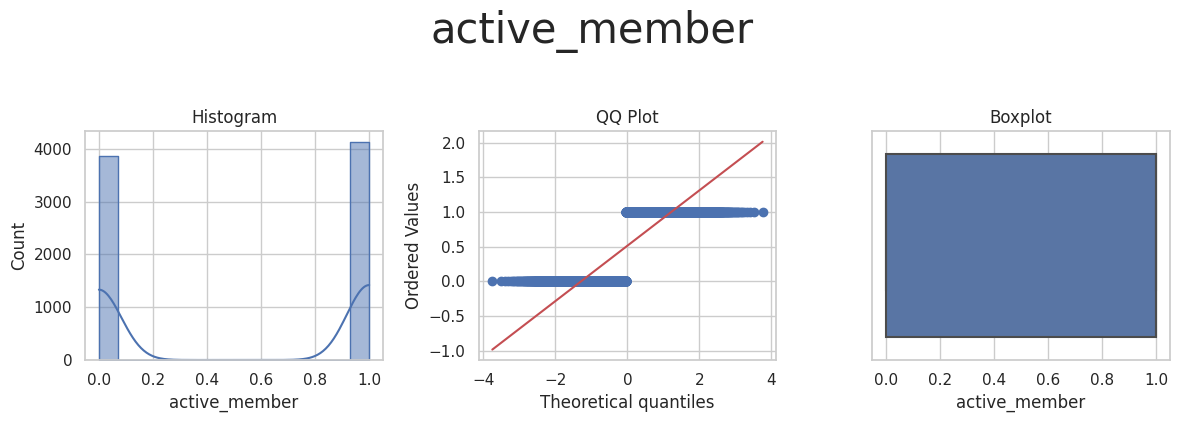

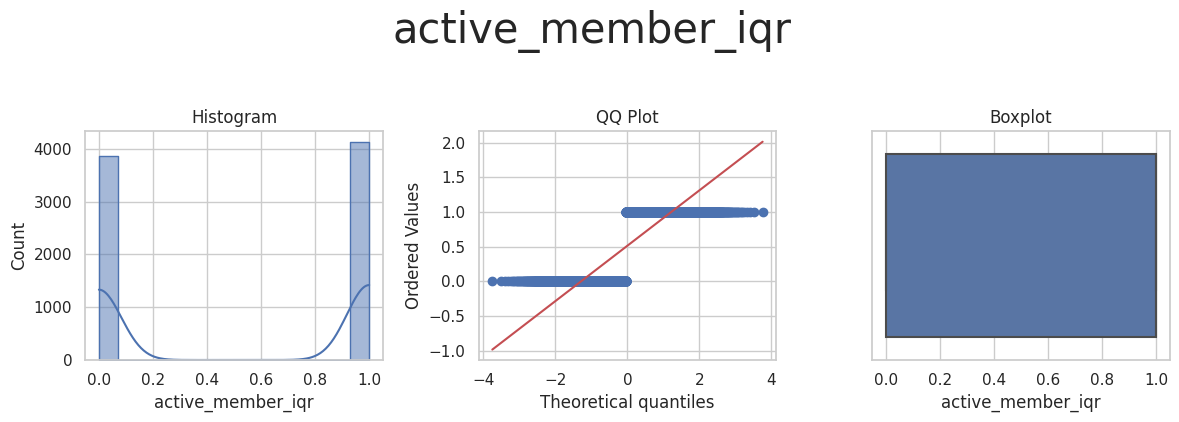



* Variable Analyzed: estimated_salary
* Applied transformation: ['estimated_salary_iqr'] 



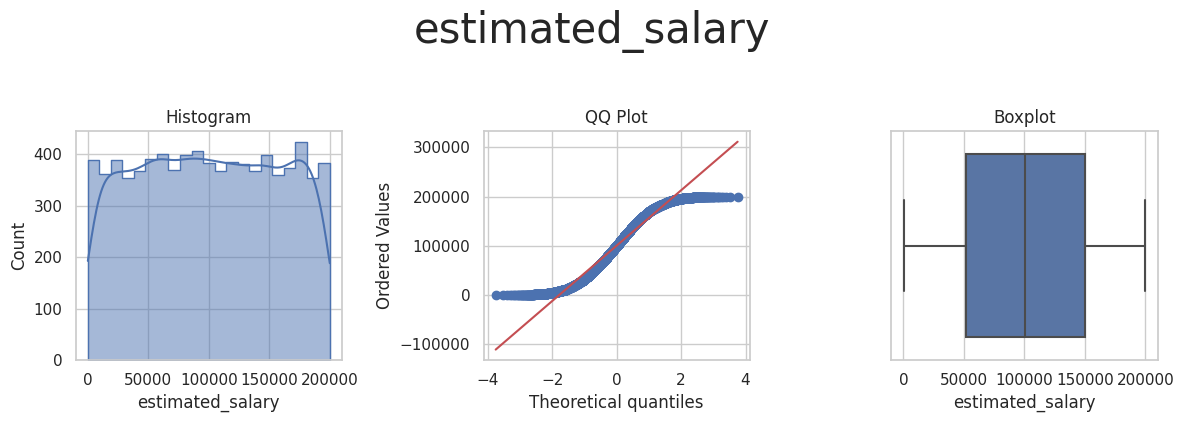

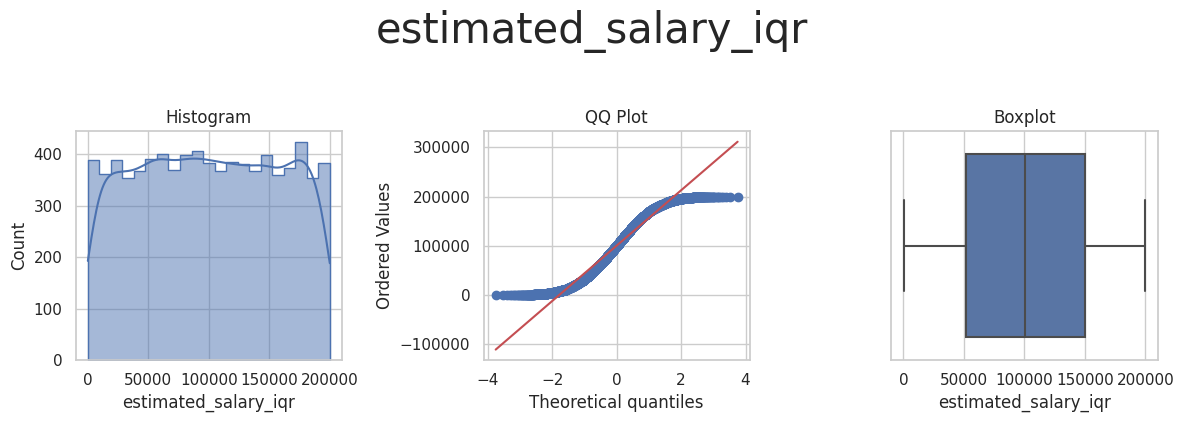

In [15]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='outlier_winsorizer')

Variables Selected: No outlier transformation selected.


## Smart Correlated Selection Variables
Finds groups of correlated features and then selects, from each group for evaluation

In [16]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(5)

credit_score  country  gender       age  tenure    balance  \
0           667        1       0  3.526361       5       0.00   
1           427        2       1  3.737670       1   75681.52   
2           535        0       0  3.367296       2  112367.34   
3           654        1       1  3.688879       5  105683.63   
4           850        1       0  4.043051       8  126776.30   

   products_number  credit_card  active_member  estimated_salary  
0                2            1              0         163830.64  
1                1            1              1          57098.00  
2                1            1              0         185630.76  
3                1            1              0         173617.09  
4                2            1              1         132298.49

In [17]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.3, selection_method="variance")

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_

[{'balance', 'products_number'}]

In [18]:
# We check which variables were removed
corr_sel.features_to_drop_

['products_number']

## Conclusions and Next steps:
The list below shows the transformations needed for feature engineering which will be added to the ML Pipeline

Feature Engineering Transforme
r
 f* Ordinal Encoder: 'country', 'gender'

 * Numerical Transformers:
   
   * Log Transformer (base e): 'age'

 * Outlier Transformer: Winzorizer: No transformation
   
    * Smart Correlated Selection: 'balance', 'products_number'

 * Dropped Variables: 'products_number.

---

---